# This file is for exploring the processed data

In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
# from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import seaborn as sn
import matplotlib.pyplot as plt
import collections
import warnings; warnings.simplefilter('ignore')
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score
from sklearn.model_selection import StratifiedKFold
from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

C:\Users\Tanner\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


First we load our dataframe

In [4]:
text_df = pd.read_pickle("data/data_frame_no_paper.pkl")
with open('data/corpus.pkl', 'rb') as f:
    corpus = pickle.load(f)

Now we generate keywords specific to the query

In [5]:
# NOTE: this code is specific to this meta-analysis


def termCombiner(pair):
    term_combos = []
    first = pair[0]
    second = pair[1]
    for term1 in first:
        for term2 in second:
            term_combos.append(term1+" "+term2)
    return term_combos

fst =  ['mechan']
snd =  ['stimul', 'perturb', 'agit', 'compress', 'strain', 'transduc', 'load', 'vibrat', 'stretch', 
        'pressur', 'press', 'displac', 'forc', 'expose', 'exposur', 'stress', 'deform', 'swell',
        'shrink', 'shrunk', 'decompress', 'stimul', 'shock']

fst1 = ['fluid']
# snd1 = snd

fst2 = ['osmotic', 'hypoton', 'hydrostat', 'hyperto','membran', 'centrifug', 'gravit']
# snd2 = snd

combos = [(fst, snd), (fst1, snd), (fst2, snd)]
query_terms = []
for combo in combos:
    query_terms.append(termCombiner(combo))

query_terms.append(['atp',
    'adenosine triphosphate'])

query_terms = [term for term_set in query_terms for term in term_set]    
# for term_set in query_terms:
#     for term in term_set:
        
query_terms = list(set(query_terms)) 
query_terms2 = list(set(query_terms + snd + fst + fst2))
with open('atprelease_query_terms1.pkl', 'wb') as f:
    pickle.dump(query_terms, f)
    
with open('atprelease_query_terms2.pkl', 'wb') as f:
    pickle.dump(query_terms2, f)

Here will will gain some general insight into how many papers have one or more of the keywords

In [6]:
text_df.columns.values

array(['original title', 'paper_id', 'title', 'original keywords',
       'keywords', 'original abstract', 'abstract', 'relevant',
       'title_corpus', 'keyword_corpus', 'abstract_corpus',
       'all_text_corpus', 'all_text', 'title_vector', 'keyword_vector',
       'abstract_vector', 'combined_text_vector'], dtype=object)

In [7]:
matches = []

# for index, paper_text in enumerate(text_df['all_text']):
#     paper_title = text_df[titles[index]]
#     paper_matches = []
#     for word in query_terms:
        
#         if word in paper_text:
#             paper_matches.append(word)
            
#     if len(paper_matches) == 0: # if no matches were found
#         paper_matches = "No Matches"
#     matches.append((paper_title, paper_matches))

for row in text_df.iterrows():
    title = " ".join(row[1]['title'])
    paper_matches = []
    for word in query_terms:
        if word in row[1]['all_text']:
            paper_matches.append(word)
    if len(paper_matches) == 0: # if no matches were found
        paper_matches = "No Matches"
    matches.append((title, paper_matches))

            

turn query_terms into a vector with same vocab as papers

In [9]:
from ipynb.fs.full.DataProcessing import nMostCommon
vect = CountVectorizer(binary = True, vocabulary = nMostCommon(corpus, 10000))

query_term_vector = vect.fit_transform([" ".join(query_terms)]).toarray()
# query_term_vector = np.asarray(query_term_vector)
query_term_vector = np.reshape(query_term_vector, (10000, ))
# query_term_vector

FileNotFoundError: [Errno 2] No such file or directory: 'finalLibrary.xml'

In [8]:
# function for getting angle between two vectors

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

# a = [i for i in range(1, 101)]
# b = [i for i in range(101, 201)]
# print(len(a)==len(b))
angle = angle_between(unit_vector(query_term_vector), unit_vector(text_df.iloc[0].combined_text_vector))
angle

1.4896632554809845

In [9]:
angles = []
for index, row in text_df.iterrows():
#     print(query_term_vector.shape)
#     print(row.combined_text_vector.shape)
    angle = angle_between(unit_vector(query_term_vector), unit_vector(row.combined_text_vector))
    angles.append(angle)
    

In [10]:
text_df = text_df.assign(combined_text_angles = angles)

In [11]:
text_df[['relevant', 'combined_text_angles']].sort_values(by = ['combined_text_angles'], ascending=True).head(10)

,relevant,combined_text_angles
180,True,1.348620
1290,False,1.350808
4961,False,1.352284
255,True,1.358126
3776,False,1.359572
146,True,1.364506
6359,False,1.365514
5301,False,1.367952
4040,False,1.367952
169,True,1.372182


In [12]:
text_df[['relevant', 'combined_text_angles']].sort_values(by = ['combined_text_angles'], ascending=True).head(4000)['relevant'].value_counts()

False    3768
True      232
Name: relevant, dtype: int64

In [13]:
# create infrastructure to plot % relevant results given number of entries returned

# next we'll employ some more sophisticated methods
Here we'll create an 'overlap vector' for each paper, where the vocab is the query terms

In [130]:
# query_terms
vect_binary = CountVectorizer(binary = True, vocabulary = query_terms)
vect_freq   = CountVectorizer(binary = False, vocabulary = query_terms)
vect_tfidf  = TfidfVectorizer(vocabulary = query_terms)

binary_overlap_vectors = vect_binary.fit_transform(text_df['all_text'])
freq_overlap_vectors = vect_freq.fit_transform(text_df['all_text'])
tfidf_overlap_vectors = vect_tfidf.fit_transform(text_df['all_text'])


In [131]:
binary_overlap_vectors = [vec for vec in binary_overlap_vectors.toarray()]
freq_overlap_vectors = [vec for vec in freq_overlap_vectors.toarray()]
tfidf_overlap_vectors = [vec for vec in tfidf_overlap_vectors.toarray()]

In [132]:
overlap_df = text_df['title'].to_frame()
overlap_df = overlap_df.assign(all_text = text_df['all_text'])
overlap_df = overlap_df.assign(binary_vector = binary_overlap_vectors)
overlap_df = overlap_df.assign(freq_vector = freq_overlap_vectors)
overlap_df = overlap_df.assign(tfidf_vector = tfidf_overlap_vectors)

relevant_vec = []
for val in text_df['relevant'].values:
    if val == True:
        relevant_vec.append(1)
    else:
        relevant_vec.append(0)
overlap_df = overlap_df.assign(relevant = relevant_vec)

overlap_df = overlap_df.sample(frac=1).reset_index(drop=True)

In [133]:
overlap_df.head()


,title,all_text,binary_vector,freq_vector,tfidf_vector,relevant
0,"[estrogen, ca2-mobil, agonist, atp, evok, acut...",estrogen ca2-mobil agonist atp evok acut synth...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,"[loss, beta1-integrin, urothelium, result, ove...",loss beta1-integrin urothelium result overact ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,"[donor, heart, preserv, pinacidil, role, mitoc...",donor heart preserv pinacidil role mitochondri...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
3,"[spin, control, oxid, phosphoryl]",spin control oxid phosphoryl spin control cont...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,"[real-tim, luminesc, imag, cellular, atp, releas]",real-tim luminesc imag cellular atp releas rea...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1


First we'll train the model with a simple train/test data partition, if the results are promising we'll repeat with a 10-fold cross validation

here we get the vectors from the dataframe

In [134]:
train, validate, test = np.split(overlap_df.sample(frac=1), [int(.6*len(overlap_df)), int(.8*len(overlap_df))])

binary_vectors_valid = validate['binary_vector'].tolist()
binary_vectors_train = train['binary_vector'].tolist()
binary_vectors_test = test['binary_vector'].tolist()

freq_vectors_valid = validate['freq_vector'].tolist()
freq_vectors_train = train['freq_vector'].tolist()
freq_vectors_test = test['freq_vector'].tolist()

tfidf_vectors_valid = validate['tfidf_vector'].tolist()
tfidf_vectors_train = train['tfidf_vector'].tolist()
tfidf_vectors_test = test['tfidf_vector'].tolist()



valid_y = validate['relevant'].values
train_y = train['relevant'].values
test_y = test['relevant'].values


# First we'll implement a bernoulli naive bayes with the binary vectors

we'll do our own cross validation, only using the alpha hyperparameter

In [112]:
# NOTE: double check the effect of chaning fit prior
# No way to improve precision or recall when fitting prior, keep as False

In [136]:
a_range0 = list(np.arange(0.001,.011, .001))
a_range1 = list(np.arange(0.01,.1, .01))
a_range2 = list(np.arange(.1, 1.1,.1))
a_range3 = list(np.arange(1,6,1))
a_range = a_range0+a_range1+a_range2 + a_range3

In [137]:
balanced_accuracy_list = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for alpha in a_range:
    clf = BernoulliNB(fit_prior = False, alpha=alpha)
    clf.fit(binary_vectors_valid, valid_y)

    pred = clf.predict(binary_vectors_test)
    
    f1 = metrics.f1_score(test_y,pred, pos_label=1)    
    balanced_accuracy = metrics.balanced_accuracy_score(test_y, pred)
    accuracy = metrics.accuracy_score(test_y,pred)
    precision = metrics.precision_score(test_y, pred, pos_label=1)
    recall = metrics.recall_score(test_y, pred, pos_label=1)
    
    accuracy_list.append(accuracy)
    balanced_accuracy_list.append(balanced_accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    
binary_scores = np.array([a_range, accuracy_list, balanced_accuracy_list, precision_list, recall_list, f1_list])


In [138]:
binary_valid_scores_df = pd.DataFrame(data = binary_scores[1:].transpose(), 
                                      index = binary_scores[0], columns = ["accuracy",'balanced accuracy', "precision", "recall", "f1"])


In [139]:
binary_valid_scores_df

,accuracy,balanced accuracy,precision,recall,f1
0.001,0.286474,0.631707,0.04203,1.0,0.08067
0.002,0.286474,0.631707,0.04203,1.0,0.08067
0.003,0.286474,0.631707,0.04203,1.0,0.08067
0.004,0.286474,0.631707,0.04203,1.0,0.08067
0.005,0.286474,0.631707,0.04203,1.0,0.08067
0.006,0.286474,0.631707,0.04203,1.0,0.08067
0.007,0.286474,0.631707,0.04203,1.0,0.08067
0.008,0.286474,0.631707,0.04203,1.0,0.08067
0.009,0.286474,0.631707,0.04203,1.0,0.08067
0.010,0.286474,0.631707,0.04203,1.0,0.08067


In [140]:
precision_scores = binary_valid_scores_df['precision'].values
recall_scores = binary_valid_scores_df['recall'].values

# plt.plot(precision_scores, recall_scores)


In [141]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(test_y, pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.03


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.03')

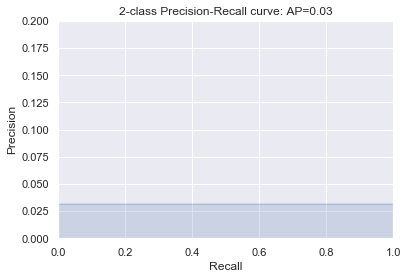

In [142]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(test_y, pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, .2])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

###### notes:
 
with an alpha of < 0.07:
    recall is close to 100%. The model is guessing correct at a very high rate as to not miss any important papers. This model is too       sensitive. The matrix below shows that it's has very few false negatives, but classifies to many papers as true

alpha >= 0.07:
    everything classified as irrelevant, all papers missed


In [143]:
clf = BernoulliNB(fit_prior = False, alpha=.05)
clf.fit(binary_vectors_train, train_y)

pred = clf.predict(binary_vectors_test)

f1 = metrics.f1_score(test_y,pred, pos_label=1)
balanced_accuracy = metrics.balanced_accuracy_score(test_y, pred)
accuracy = metrics.accuracy_score(test_y,pred)
precision = metrics.precision_score(test_y,pred, pos_label=1)
recall = metrics.recall_score(test_y,pred, pos_label=1)


print("accuracy:  {}" .format(accuracy))
print("precision: {}" .format(precision))
print("recall:    {}" .format(recall))
print("f1 score:  {}" .format(f1))


accuracy:  0.2864737152982871
precision: 0.04203013481363997
recall:    1.0
f1 score:  0.0806697108066971


Final confusion matrix given optimal alpha parameter

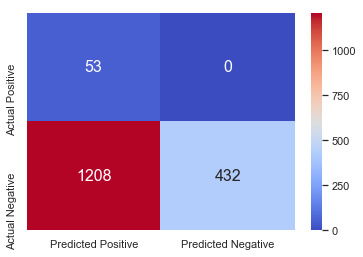

In [144]:
matrix = cm(test_y, pred, labels = [1, 0])
df_cm = pd.DataFrame(matrix, range(2), range(2))
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, cmap='coolwarm', fmt='g', xticklabels = ["Predicted Positive", "Predicted Negative"], yticklabels = ["Actual Positive", "Actual Negative"])# font size

# here we explore the precision recall tradeoff and see if we can gain intuition into how to nudge the model to yield higher precision

plot how alpha value (controls laplace smoothing) effects various metrics

In [145]:
score_list = []

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
a_range = list(np.arange(0,.5, .01))

for alpha_val in a_range:
    clf = BernoulliNB(fit_prior = False, alpha=alpha_val)
    clf.fit(binary_vectors_train, train_y)

    pred = clf.predict(binary_vectors_test)

    f1 = metrics.f1_score(test_y,pred, average='micro')
    accuracy = metrics.accuracy_score(test_y,pred)
    precision = metrics.precision_score(test_y,pred)
    recall = metrics.recall_score(test_y,pred)
    score_list.append((accuracy, precision, recall, f1))
    
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    
scores = np.array([a_range, accuracy_list, precision_list, recall_list, f1_list])

In [146]:
scores_df = pd.DataFrame(data = scores[1:].transpose(), 
                         index = scores[0], columns = ["accuracy", "precision", "recall", "f1"])


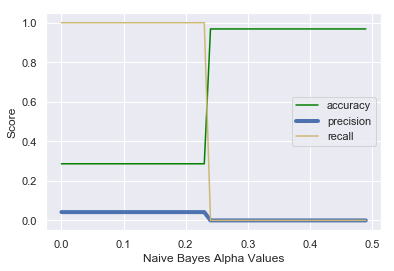

In [147]:

plt.plot(scores_df.index.values, scores_df['accuracy'], color='green', label = 'accuracy')
plt.plot(scores_df.index.values, scores_df['precision'], color='b', label = 'precision', linewidth = 4)
plt.plot(scores_df.index.values, scores_df['recall'], color='y', label = 'recall')
plt.xlabel("Naive Bayes Alpha Values")
plt.ylabel("Score")
plt.legend()
# plt.plot(scores_df.index.values, scores_df['f1'], color='orange')

plt.show()



In [69]:
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

param_grid = {
    'alpha': a_range
}

In [207]:

def grid_search_wrapper(vector_type, classifier, param_grid, scorers, refit_score='precision_score'):
    if classifier == 'svm':
        clf = SVC()
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    
    
    print(clf)
    if vector_type == 'binary':
        skf = StratifiedKFold(n_splits=10)
        grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                               cv=skf, return_train_score=True, n_jobs=-1)
        grid_search.fit(binary_vectors_valid, valid_y)

        # make the predictions
        y_pred = grid_search.predict(binary_vectors_test)

        print('Best params for {}'.format(refit_score))
        print(grid_search.best_params_)

        # confusion matrix on the test data.
        print('\nConfusion matrix of Bernoulli Naive Bayes optimized for {} on the test data:'.format(refit_score))
        print(pd.DataFrame(cm(test_y, y_pred),
                     columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
        
    elif vector_type == 'freq':
        print("frequency vectors")
        skf = StratifiedKFold(n_splits=3)
        grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                               cv=skf, return_train_score=True, n_jobs=-1)
        grid_search.fit(freq_vectors_valid, valid_y)

        # make the predictions
        y_pred = grid_search.predict(freq_vectors_test)

        print('Best params for {}'.format(refit_score))
        print(grid_search.best_params_)

        # confusion matrix on the test data.
        print('\nConfusion matrix of Bernoulli Naive Bayes optimized for {} on the test data:'.format(refit_score))
        print(pd.DataFrame(cm(test_y, y_pred),
                     columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    else:
        print("tfidf vectors")
        skf = StratifiedKFold(n_splits=3)
        
        grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                               cv=skf, return_train_score=True, verbose=2)
        
        grid_search.fit(tfidf_vectors_valid, valid_y)

        # make the predictions
        y_pred = grid_search.predict(tfidf_vectors_test)

        print('Best params for {}'.format(refit_score))
        print(grid_search.best_params_)

        # confusion matrix on the test data.
        print('\nConfusion matrix of Bernoulli Naive Bayes optimized for {} on the test data:'.format(refit_score))
        print(pd.DataFrame(cm(test_y, y_pred),
                     columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
        
    return grid_search

In [205]:
# grid_search_clf_precision = grid_search_wrapper('binary', refit_score='precision_score')

both precision and recall metrics yeild identical results. 

In [65]:
results_recall = pd.DataFrame(grid_search_clf_recall.cv_results_)

get datapoints for a precision-recall comparison

In [149]:
y_prob_scores = grid_search_clf_precision.predict_proba(binary_vectors_test)[:, 1]
p, r, thresholds = precision_recall_curve(test_y, y_prob_scores)


In [150]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_prob_scores]



def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_prob_scores, t)
    print(pd.DataFrame(cm(test_y, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))


In [151]:
threshold_range = list(np.arange(0.55, .61, .001))
for threshold in threshold_range:
    print(threshold)
    precision_recall_threshold(p, r, thresholds, threshold)
    print('\n')

0.55
     pred_neg  pred_pos
neg      1640         0
pos        53         0


0.551
     pred_neg  pred_pos
neg      1640         0
pos        53         0


0.552
     pred_neg  pred_pos
neg      1640         0
pos        53         0


0.553
     pred_neg  pred_pos
neg      1640         0
pos        53         0


0.554
     pred_neg  pred_pos
neg      1640         0
pos        53         0


0.555
     pred_neg  pred_pos
neg      1640         0
pos        53         0


0.556
     pred_neg  pred_pos
neg      1640         0
pos        53         0


0.557
     pred_neg  pred_pos
neg      1640         0
pos        53         0


0.558
     pred_neg  pred_pos
neg      1640         0
pos        53         0


0.559
     pred_neg  pred_pos
neg      1640         0
pos        53         0


0.56
     pred_neg  pred_pos
neg      1640         0
pos        53         0


0.561
     pred_neg  pred_pos
neg      1640         0
pos        53         0


0.562
     pred_neg  pred_pos
neg      164

We see a dramatic jump when the threshold is above 0.578. The suddenness of the drop leave little room for experimentation. We'll assume the results obtained with a threshold below 0.578 are optimal (for now)

this corroborates what we saw in the adjusting of the alpha parameter (an extremely sudden jump)

here we attempt to plot recall and precision as a function of the threshold. 
Because of the sudden jump, the function returned only one threshold returned,
thus there is nothing to plot, there is only the scores before this point and after 
(which is shown by the confusion matrices above)

In [152]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

In [153]:
# plot_precision_recall_vs_threshold(p, r, thresholds)

the lack of precision vs recall information makes exploring this issue difficult

# Bernoulli Naive Bayes with frequency vectors

first we'll narrow in on the alpha value that gives an interesting look at the metrics

In [41]:
a_range0 = list(np.arange(0.001,.01, .001))
a_range1 = list(np.arange(0.01,.2, .01))
# a_range2 = list(np.arange(.1, 1,.1))
# a_range3 = list(np.arange(1,6,1))
a_range = a_range0 + a_range1 + a_range2 #+ a_range3
a_range_focused = list(np.arange(.096064, .096066, .0000001))
# a_range

In [42]:
balanced_accuracy_list = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for alpha in a_range:
    clf = BernoulliNB(fit_prior = False, alpha=alpha)
    clf.fit(freq_vectors_valid, valid_y)

    pred = clf.predict(freq_vectors_test)
    
    f1 = metrics.f1_score(test_y,pred, pos_label=1)    
    balanced_accuracy = metrics.balanced_accuracy_score(test_y, pred)
    accuracy = metrics.accuracy_score(test_y,pred)
    precision = metrics.precision_score(test_y, pred, pos_label=1)
    recall = metrics.recall_score(test_y, pred, pos_label=1)
    
    accuracy_list.append(accuracy)
    balanced_accuracy_list.append(balanced_accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    
freq_scores = np.array([a_range, accuracy_list, balanced_accuracy_list, precision_list, recall_list, f1_list])


In [43]:
balanced_accuracy_list = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for alpha in a_range_focused:
    clf = BernoulliNB(fit_prior = False, alpha=alpha)
    clf.fit(freq_vectors_valid, valid_y)

    pred = clf.predict(freq_vectors_test)
    
    f1 = metrics.f1_score(test_y,pred, pos_label=1)    
    balanced_accuracy = metrics.balanced_accuracy_score(test_y, pred)
    accuracy = metrics.accuracy_score(test_y,pred)
    precision = metrics.precision_score(test_y, pred, pos_label=1)
    recall = metrics.recall_score(test_y, pred, pos_label=1)
    
    accuracy_list.append(accuracy)
    balanced_accuracy_list.append(balanced_accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    
freq_scores_focused = np.array([a_range_focused, accuracy_list, balanced_accuracy_list, precision_list, recall_list, f1_list])


In [44]:
freq_valid_scores_df = pd.DataFrame(data = freq_scores[1:].transpose(), 
                                      index = freq_scores[0], columns = ["accuracy",'balanced accuracy', "precision", "recall", "f1"])
# freq_valid_scores_df

In [45]:
focused_freq_valid_scores_df = pd.DataFrame(data = freq_scores_focused[1:].transpose(), 
                                      index = freq_scores_focused[0], columns = ["accuracy",'balanced accuracy', "precision", "recall", "f1"])
# focused_freq_valid_scores_df

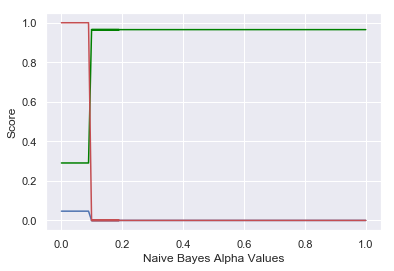

In [46]:

plt.plot(freq_valid_scores_df.index.values, freq_valid_scores_df['accuracy'], color='green')
plt.plot(freq_valid_scores_df.index.values, freq_valid_scores_df['precision'], color='b')
plt.plot(freq_valid_scores_df.index.values, freq_valid_scores_df['recall'], color='r')
plt.xlabel("Naive Bayes Alpha Values")
plt.ylabel("Score")
# plt.plot(scores_df.index.values, scores_df['f1'], color='orange')

plt.show()


In [165]:
# plt.plot(focused_freq_valid_scores_df.index.values, focused_freq_valid_scores_df['accuracy'], color='green')
# plt.plot(focused_freq_valid_scores_df.index.values, focused_freq_valid_scores_df['precision'], color='b')
# plt.plot(focused_freq_valid_scores_df.index.values, focused_freq_valid_scores_df['recall'], color='r')
# plt.xlabel("Naive Bayes Alpha Values")
# plt.ylabel("Score")
# # plt.plot(scores_df.index.values, scores_df['f1'], color='orange')

# plt.show()


We see that no matter how narrow the alpha range is, we can't pinpoint the turning point

In [48]:
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}
binarize_list = list(np.arange(0, 1.0, .01))

param_grid = {
    'alpha': a_range,
    'fit_prior': [True, False],
    'binarize': binarize_list    
}

In [160]:
grid_search_clf_precision = grid_search_wrapper(False, refit_score='precision_score')

In [ ]:
results_precision = pd.DataFrame(grid_search_clf_precision.cv_results_)
results_precision

In [ ]:
grid_search_clf_precision = grid_search_wrapper(False, refit_score='recall_score')

In [154]:
y_prob_scores = grid_search_clf_precision.predict_proba(freq_vectors_test)[:, 1]
p, r, thresholds = precision_recall_curve(test_y, y_prob_scores)

In [155]:
threshold_range = list(np.arange(0, .05, .001))
for threshold in threshold_range:
    print(threshold)
    precision_recall_threshold(p, r, thresholds, threshold)
    print('\n')

0.0
     pred_neg  pred_pos
neg         0      1640
pos         0        53


0.001
     pred_neg  pred_pos
neg       432      1208
pos         0        53


0.002
     pred_neg  pred_pos
neg       432      1208
pos         0        53


0.003
     pred_neg  pred_pos
neg       432      1208
pos         0        53


0.004
     pred_neg  pred_pos
neg       432      1208
pos         0        53


0.005
     pred_neg  pred_pos
neg       432      1208
pos         0        53


0.006
     pred_neg  pred_pos
neg       432      1208
pos         0        53


0.007
     pred_neg  pred_pos
neg       432      1208
pos         0        53


0.008
     pred_neg  pred_pos
neg       432      1208
pos         0        53


0.009000000000000001
     pred_neg  pred_pos
neg       432      1208
pos         0        53


0.01
     pred_neg  pred_pos
neg       432      1208
pos         0        53


0.011
     pred_neg  pred_pos
neg       432      1208
pos         0        53


0.012
     pred_neg  pred_po

In [156]:
clf = BernoulliNB(fit_prior = False, alpha=.001)
clf.fit(freq_vectors_train, train_y)

pred = clf.predict(freq_vectors_test)

f1 = metrics.f1_score(test_y,pred, pos_label=1)
balanced_accuracy = metrics.balanced_accuracy_score(test_y, pred)
accuracy = metrics.accuracy_score(test_y,pred)
precision = metrics.precision_score(test_y,pred, pos_label=1)
recall = metrics.recall_score(test_y,pred, pos_label=1)


print(accuracy)
print(precision)
print(recall)
print(f1)


0.2864737152982871
0.04203013481363997
1.0
0.0806697108066971


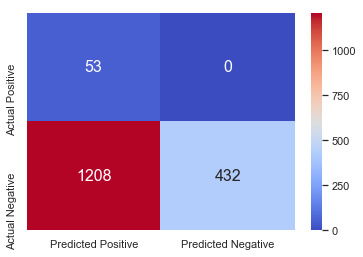

In [157]:
matrix = cm(test_y, pred, labels = [1, 0])
df_cm = pd.DataFrame(matrix, range(2), range(2))
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, cmap='coolwarm', fmt='g', 
           xticklabels = ["Predicted Positive", "Predicted Negative"], yticklabels = ["Actual Positive", "Actual Negative"])# font size

# Now we'll try tf_idf

In [162]:
balanced_accuracy_list = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for alpha in a_range:
    clf = BernoulliNB(fit_prior = False, alpha=alpha)
    clf.fit(tfidf_vectors_valid, valid_y)

    prediction = clf.predict(tfidf_vectors_test)
    
    f1 = metrics.f1_score(test_y,pred, pos_label=1)    
    balanced_accuracy = metrics.balanced_accuracy_score(test_y, prediction)
    accuracy = metrics.accuracy_score(test_y,prediction)
    precision = metrics.precision_score(test_y, prediction, pos_label=1)
    recall = metrics.recall_score(test_y, prediction, pos_label=1)
    
    accuracy_list.append(accuracy)
    balanced_accuracy_list.append(balanced_accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    
tfidf_scores = np.array([a_range, accuracy_list, balanced_accuracy_list, precision_list, recall_list, f1_list])

In [163]:
tfidf_valid_scores_df = pd.DataFrame(data = tfidf_scores[1:].transpose(), 
                                      index = tfidf_scores[0], columns = ["accuracy",'balanced accuracy', "precision", "recall", "f1"])


In [164]:
tfidf_valid_scores_df

,accuracy,balanced accuracy,precision,recall,f1
0.00,0.286474,0.631707,0.04203,1.0,0.08067
0.01,0.286474,0.631707,0.04203,1.0,0.08067
0.02,0.286474,0.631707,0.04203,1.0,0.08067
0.03,0.286474,0.631707,0.04203,1.0,0.08067
0.04,0.286474,0.631707,0.04203,1.0,0.08067
0.05,0.286474,0.631707,0.04203,1.0,0.08067
0.06,0.286474,0.631707,0.04203,1.0,0.08067
0.07,0.286474,0.631707,0.04203,1.0,0.08067
0.08,0.286474,0.631707,0.04203,1.0,0.08067
0.09,0.286474,0.631707,0.04203,1.0,0.08067


In [168]:
clf = BernoulliNB(fit_prior = False, alpha=.01)
clf.fit(tfidf_vectors_train, train_y)

prediction = clf.predict(tfidf_vectors_test)

f1 = metrics.f1_score(test_y, prediction, pos_label=1)
balanced_accuracy = metrics.balanced_accuracy_score(test_y, prediction)
accuracy = metrics.accuracy_score(test_y,prediction)
precision = metrics.precision_score(test_y,prediction, pos_label=1)
recall = metrics.recall_score(test_y,prediction, pos_label=1)



print("accuracy:  {}" .format(accuracy))
print("precision: {}" .format(precision))
print("recall:    {}" .format(recall))
print("f1 score:  {}" .format(f1))


accuracy:  0.2864737152982871
precision: 0.04203013481363997
recall:    1.0
f1 score:  0.0806697108066971


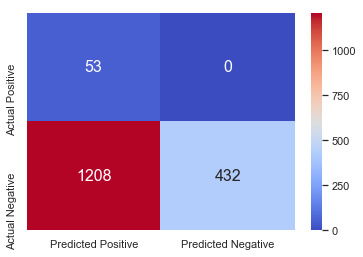

In [169]:
matrix = cm(test_y, prediction, labels = [1, 0])
df_cm = pd.DataFrame(matrix, range(2), range(2))
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, cmap='coolwarm', fmt='g', 
           xticklabels = ["Predicted Positive", "Predicted Negative"], yticklabels = ["Actual Positive", "Actual Negative"])# font size

# now we'll test a SVM

In [198]:
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

c = gamma =  list(np.logspace(-2, 1, num=10))
kernel = ['linear', 'poly', 'rbf']


param_grid = {
    'C': c,
    'kernel': kernel,
    'gamma': gamma,
    'degree': [2,3]
}

In [208]:
clf = SVC()
grid_search_clf_precision = grid_search_wrapper('tfidf','svm', param_grid, scorers, refit_score='precision_score')

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
tfidf vectors
Fitting 3 folds for each of 600 candidates, totalling 1800 fits
[CV] C=0.01, degree=2, gamma=0.01, kernel=linear .....................
[CV] ...... C=0.01, degree=2, gamma=0.01, kernel=linear, total=   0.0s
[CV] C=0.01, degree=2, gamma=0.01, kernel=linear .....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ...... C=0.01, degree=2, gamma=0.01, kernel=linear, total=   0.0s
[CV] C=0.01, degree=2, gamma=0.01, kernel=linear .....................
[CV] ...... C=0.01, degree=2, gamma=0.01, kernel=linear, total=   0.0s
[CV] C=0.01, degree=2, gamma=0.01, kernel=poly .......................
[CV] ........ C=0.01, degree=2, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=0.01, degree=2, gamma=0.01, kernel=poly .......................
[CV] ........ C=0.01, degree=2, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=0.01, degree=2, gamma=0.01, kernel=poly .......................
[CV] ........ C=0.01, degree=2, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=0.01, degree=2, gamma=0.01, kernel=rbf ........................
[CV] ......... C=0.01, degree=2, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.01, degree=2, gamma=0.01, kernel=rbf ........................
[CV] ......... C=0.01, degree=2, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.01, degree=2, gamma=0.01, kernel=rbf ........................
[CV] .

[CV] ......... C=0.01, degree=2, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=0.01, degree=2, gamma=1.0, kernel=poly ........................
[CV] ......... C=0.01, degree=2, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=0.01, degree=2, gamma=1.0, kernel=rbf .........................
[CV] .......... C=0.01, degree=2, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=0.01, degree=2, gamma=1.0, kernel=rbf .........................
[CV] .......... C=0.01, degree=2, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=0.01, degree=2, gamma=1.0, kernel=rbf .........................
[CV] .......... C=0.01, degree=2, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=0.01, degree=2, gamma=2.154434690031882, kernel=linear ........
[CV]  C=0.01, degree=2, gamma=2.154434690031882, kernel=linear, total=   0.0s
[CV] C=0.01, degree=2, gamma=2.154434690031882, kernel=linear ........
[CV]  C=0.01, degree=2, gamma=2.154434690031882, kernel=linear, total=   0.0s
[CV] C=0.01, degree=2, gamma=2.154434690031882, kernel=linear .

[CV]  C=0.01, degree=3, gamma=0.046415888336127774, kernel=rbf, total=   0.0s
[CV] C=0.01, degree=3, gamma=0.1, kernel=linear ......................
[CV] ....... C=0.01, degree=3, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=0.01, degree=3, gamma=0.1, kernel=linear ......................
[CV] ....... C=0.01, degree=3, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=0.01, degree=3, gamma=0.1, kernel=linear ......................
[CV] ....... C=0.01, degree=3, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=0.01, degree=3, gamma=0.1, kernel=poly ........................
[CV] ......... C=0.01, degree=3, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.01, degree=3, gamma=0.1, kernel=poly ........................
[CV] ......... C=0.01, degree=3, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.01, degree=3, gamma=0.1, kernel=poly ........................
[CV] ......... C=0.01, degree=3, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.01, degree=3, gamma=0.1, kernel=rbf .........................

[CV] ...... C=0.01, degree=3, gamma=10.0, kernel=linear, total=   0.0s
[CV] C=0.01, degree=3, gamma=10.0, kernel=poly .......................
[CV] ........ C=0.01, degree=3, gamma=10.0, kernel=poly, total=   0.0s
[CV] C=0.01, degree=3, gamma=10.0, kernel=poly .......................
[CV] ........ C=0.01, degree=3, gamma=10.0, kernel=poly, total=   0.0s
[CV] C=0.01, degree=3, gamma=10.0, kernel=poly .......................
[CV] ........ C=0.01, degree=3, gamma=10.0, kernel=poly, total=   0.0s
[CV] C=0.01, degree=3, gamma=10.0, kernel=rbf ........................
[CV] ......... C=0.01, degree=3, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=0.01, degree=3, gamma=10.0, kernel=rbf ........................
[CV] ......... C=0.01, degree=3, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=0.01, degree=3, gamma=10.0, kernel=rbf ........................
[CV] ......... C=0.01, degree=3, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=0.021544346900318832, degree=2, gamma=0.01, kernel=linear .....
[CV]  

[CV]  C=0.021544346900318832, degree=2, gamma=0.46415888336127775, kernel=linear, total=   0.0s
[CV] C=0.021544346900318832, degree=2, gamma=0.46415888336127775, kernel=linear 
[CV]  C=0.021544346900318832, degree=2, gamma=0.46415888336127775, kernel=linear, total=   0.0s
[CV] C=0.021544346900318832, degree=2, gamma=0.46415888336127775, kernel=linear 
[CV]  C=0.021544346900318832, degree=2, gamma=0.46415888336127775, kernel=linear, total=   0.0s
[CV] C=0.021544346900318832, degree=2, gamma=0.46415888336127775, kernel=poly 
[CV]  C=0.021544346900318832, degree=2, gamma=0.46415888336127775, kernel=poly, total=   0.0s
[CV] C=0.021544346900318832, degree=2, gamma=0.46415888336127775, kernel=poly 
[CV]  C=0.021544346900318832, degree=2, gamma=0.46415888336127775, kernel=poly, total=   0.0s
[CV] C=0.021544346900318832, degree=2, gamma=0.46415888336127775, kernel=poly 
[CV]  C=0.021544346900318832, degree=2, gamma=0.46415888336127775, kernel=poly, total=   0.0s
[CV] C=0.021544346900318832, de

[CV]  C=0.021544346900318832, degree=3, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.021544346900318832, degree=3, gamma=0.01, kernel=rbf ........
[CV]  C=0.021544346900318832, degree=3, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.021544346900318832, degree=3, gamma=0.021544346900318832, kernel=linear 
[CV]  C=0.021544346900318832, degree=3, gamma=0.021544346900318832, kernel=linear, total=   0.0s
[CV] C=0.021544346900318832, degree=3, gamma=0.021544346900318832, kernel=linear 
[CV]  C=0.021544346900318832, degree=3, gamma=0.021544346900318832, kernel=linear, total=   0.0s
[CV] C=0.021544346900318832, degree=3, gamma=0.021544346900318832, kernel=linear 
[CV]  C=0.021544346900318832, degree=3, gamma=0.021544346900318832, kernel=linear, total=   0.0s
[CV] C=0.021544346900318832, degree=3, gamma=0.021544346900318832, kernel=poly 
[CV]  C=0.021544346900318832, degree=3, gamma=0.021544346900318832, kernel=poly, total=   0.0s
[CV] C=0.021544346900318832, degree=3, gamma=0.02154434690031

[CV]  C=0.021544346900318832, degree=3, gamma=1.0, kernel=linear, total=   0.0s
[CV] C=0.021544346900318832, degree=3, gamma=1.0, kernel=poly ........
[CV]  C=0.021544346900318832, degree=3, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=0.021544346900318832, degree=3, gamma=1.0, kernel=poly ........
[CV]  C=0.021544346900318832, degree=3, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=0.021544346900318832, degree=3, gamma=1.0, kernel=poly ........
[CV]  C=0.021544346900318832, degree=3, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=0.021544346900318832, degree=3, gamma=1.0, kernel=rbf .........
[CV]  C=0.021544346900318832, degree=3, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=0.021544346900318832, degree=3, gamma=1.0, kernel=rbf .........
[CV]  C=0.021544346900318832, degree=3, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=0.021544346900318832, degree=3, gamma=1.0, kernel=rbf .........
[CV]  C=0.021544346900318832, degree=3, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=0.021544346900318832, 

[CV]  C=0.046415888336127774, degree=2, gamma=0.021544346900318832, kernel=rbf, total=   0.0s
[CV] C=0.046415888336127774, degree=2, gamma=0.046415888336127774, kernel=linear 
[CV]  C=0.046415888336127774, degree=2, gamma=0.046415888336127774, kernel=linear, total=   0.0s
[CV] C=0.046415888336127774, degree=2, gamma=0.046415888336127774, kernel=linear 
[CV]  C=0.046415888336127774, degree=2, gamma=0.046415888336127774, kernel=linear, total=   0.0s
[CV] C=0.046415888336127774, degree=2, gamma=0.046415888336127774, kernel=linear 
[CV]  C=0.046415888336127774, degree=2, gamma=0.046415888336127774, kernel=linear, total=   0.0s
[CV] C=0.046415888336127774, degree=2, gamma=0.046415888336127774, kernel=poly 
[CV]  C=0.046415888336127774, degree=2, gamma=0.046415888336127774, kernel=poly, total=   0.0s
[CV] C=0.046415888336127774, degree=2, gamma=0.046415888336127774, kernel=poly 
[CV]  C=0.046415888336127774, degree=2, gamma=0.046415888336127774, kernel=poly, total=   0.0s
[CV] C=0.0464158883

[CV]  C=0.046415888336127774, degree=2, gamma=2.154434690031882, kernel=poly, total=   0.0s
[CV] C=0.046415888336127774, degree=2, gamma=2.154434690031882, kernel=poly 
[CV]  C=0.046415888336127774, degree=2, gamma=2.154434690031882, kernel=poly, total=   0.0s
[CV] C=0.046415888336127774, degree=2, gamma=2.154434690031882, kernel=rbf 
[CV]  C=0.046415888336127774, degree=2, gamma=2.154434690031882, kernel=rbf, total=   0.0s
[CV] C=0.046415888336127774, degree=2, gamma=2.154434690031882, kernel=rbf 
[CV]  C=0.046415888336127774, degree=2, gamma=2.154434690031882, kernel=rbf, total=   0.0s
[CV] C=0.046415888336127774, degree=2, gamma=2.154434690031882, kernel=rbf 
[CV]  C=0.046415888336127774, degree=2, gamma=2.154434690031882, kernel=rbf, total=   0.0s
[CV] C=0.046415888336127774, degree=2, gamma=4.6415888336127775, kernel=linear 
[CV]  C=0.046415888336127774, degree=2, gamma=4.6415888336127775, kernel=linear, total=   0.0s
[CV] C=0.046415888336127774, degree=2, gamma=4.6415888336127775

[CV]  C=0.046415888336127774, degree=3, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=0.046415888336127774, degree=3, gamma=0.1, kernel=linear ......
[CV]  C=0.046415888336127774, degree=3, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=0.046415888336127774, degree=3, gamma=0.1, kernel=linear ......
[CV]  C=0.046415888336127774, degree=3, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=0.046415888336127774, degree=3, gamma=0.1, kernel=poly ........
[CV]  C=0.046415888336127774, degree=3, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.046415888336127774, degree=3, gamma=0.1, kernel=poly ........
[CV]  C=0.046415888336127774, degree=3, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.046415888336127774, degree=3, gamma=0.1, kernel=poly ........
[CV]  C=0.046415888336127774, degree=3, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.046415888336127774, degree=3, gamma=0.1, kernel=rbf .........
[CV]  C=0.046415888336127774, degree=3, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.04641588833612

[CV]  C=0.046415888336127774, degree=3, gamma=4.6415888336127775, kernel=poly, total=   0.0s
[CV] C=0.046415888336127774, degree=3, gamma=4.6415888336127775, kernel=rbf 
[CV]  C=0.046415888336127774, degree=3, gamma=4.6415888336127775, kernel=rbf, total=   0.0s
[CV] C=0.046415888336127774, degree=3, gamma=4.6415888336127775, kernel=rbf 
[CV]  C=0.046415888336127774, degree=3, gamma=4.6415888336127775, kernel=rbf, total=   0.0s
[CV] C=0.046415888336127774, degree=3, gamma=4.6415888336127775, kernel=rbf 
[CV]  C=0.046415888336127774, degree=3, gamma=4.6415888336127775, kernel=rbf, total=   0.0s
[CV] C=0.046415888336127774, degree=3, gamma=10.0, kernel=linear .....
[CV]  C=0.046415888336127774, degree=3, gamma=10.0, kernel=linear, total=   0.0s
[CV] C=0.046415888336127774, degree=3, gamma=10.0, kernel=linear .....
[CV]  C=0.046415888336127774, degree=3, gamma=10.0, kernel=linear, total=   0.0s
[CV] C=0.046415888336127774, degree=3, gamma=10.0, kernel=linear .....
[CV]  C=0.046415888336127

[CV]  C=0.1, degree=2, gamma=0.21544346900318834, kernel=rbf, total=   0.0s
[CV] C=0.1, degree=2, gamma=0.21544346900318834, kernel=rbf ..........
[CV]  C=0.1, degree=2, gamma=0.21544346900318834, kernel=rbf, total=   0.0s
[CV] C=0.1, degree=2, gamma=0.46415888336127775, kernel=linear .......
[CV]  C=0.1, degree=2, gamma=0.46415888336127775, kernel=linear, total=   0.0s
[CV] C=0.1, degree=2, gamma=0.46415888336127775, kernel=linear .......
[CV]  C=0.1, degree=2, gamma=0.46415888336127775, kernel=linear, total=   0.0s
[CV] C=0.1, degree=2, gamma=0.46415888336127775, kernel=linear .......
[CV]  C=0.1, degree=2, gamma=0.46415888336127775, kernel=linear, total=   0.0s
[CV] C=0.1, degree=2, gamma=0.46415888336127775, kernel=poly .........
[CV]  C=0.1, degree=2, gamma=0.46415888336127775, kernel=poly, total=   0.0s
[CV] C=0.1, degree=2, gamma=0.46415888336127775, kernel=poly .........
[CV]  C=0.1, degree=2, gamma=0.46415888336127775, kernel=poly, total=   0.0s
[CV] C=0.1, degree=2, gamma=0.4

[CV]  C=0.1, degree=3, gamma=0.021544346900318832, kernel=linear, total=   0.0s
[CV] C=0.1, degree=3, gamma=0.021544346900318832, kernel=linear ......
[CV]  C=0.1, degree=3, gamma=0.021544346900318832, kernel=linear, total=   0.0s
[CV] C=0.1, degree=3, gamma=0.021544346900318832, kernel=poly ........
[CV]  C=0.1, degree=3, gamma=0.021544346900318832, kernel=poly, total=   0.0s
[CV] C=0.1, degree=3, gamma=0.021544346900318832, kernel=poly ........
[CV]  C=0.1, degree=3, gamma=0.021544346900318832, kernel=poly, total=   0.0s
[CV] C=0.1, degree=3, gamma=0.021544346900318832, kernel=poly ........
[CV]  C=0.1, degree=3, gamma=0.021544346900318832, kernel=poly, total=   0.0s
[CV] C=0.1, degree=3, gamma=0.021544346900318832, kernel=rbf .........
[CV]  C=0.1, degree=3, gamma=0.021544346900318832, kernel=rbf, total=   0.0s
[CV] C=0.1, degree=3, gamma=0.021544346900318832, kernel=rbf .........
[CV]  C=0.1, degree=3, gamma=0.021544346900318832, kernel=rbf, total=   0.0s
[CV] C=0.1, degree=3, gamm

[CV]  C=0.1, degree=3, gamma=2.154434690031882, kernel=poly, total=   0.0s
[CV] C=0.1, degree=3, gamma=2.154434690031882, kernel=poly ...........
[CV]  C=0.1, degree=3, gamma=2.154434690031882, kernel=poly, total=   0.0s
[CV] C=0.1, degree=3, gamma=2.154434690031882, kernel=poly ...........
[CV]  C=0.1, degree=3, gamma=2.154434690031882, kernel=poly, total=   0.0s
[CV] C=0.1, degree=3, gamma=2.154434690031882, kernel=rbf ............
[CV]  C=0.1, degree=3, gamma=2.154434690031882, kernel=rbf, total=   0.0s
[CV] C=0.1, degree=3, gamma=2.154434690031882, kernel=rbf ............
[CV]  C=0.1, degree=3, gamma=2.154434690031882, kernel=rbf, total=   0.0s
[CV] C=0.1, degree=3, gamma=2.154434690031882, kernel=rbf ............
[CV]  C=0.1, degree=3, gamma=2.154434690031882, kernel=rbf, total=   0.0s
[CV] C=0.1, degree=3, gamma=4.6415888336127775, kernel=linear ........
[CV]  C=0.1, degree=3, gamma=4.6415888336127775, kernel=linear, total=   0.0s
[CV] C=0.1, degree=3, gamma=4.6415888336127775, k

[CV]  C=0.21544346900318834, degree=2, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=0.21544346900318834, degree=2, gamma=0.1, kernel=poly .........
[CV]  C=0.21544346900318834, degree=2, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.21544346900318834, degree=2, gamma=0.1, kernel=poly .........
[CV]  C=0.21544346900318834, degree=2, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.21544346900318834, degree=2, gamma=0.1, kernel=poly .........
[CV]  C=0.21544346900318834, degree=2, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.21544346900318834, degree=2, gamma=0.1, kernel=rbf ..........
[CV]  C=0.21544346900318834, degree=2, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.21544346900318834, degree=2, gamma=0.1, kernel=rbf ..........
[CV]  C=0.21544346900318834, degree=2, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.21544346900318834, degree=2, gamma=0.1, kernel=rbf ..........
[CV]  C=0.21544346900318834, degree=2, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.21544346900318834, degree=2

[CV]  C=0.21544346900318834, degree=2, gamma=10.0, kernel=linear, total=   0.0s
[CV] C=0.21544346900318834, degree=2, gamma=10.0, kernel=linear ......
[CV]  C=0.21544346900318834, degree=2, gamma=10.0, kernel=linear, total=   0.0s
[CV] C=0.21544346900318834, degree=2, gamma=10.0, kernel=linear ......
[CV]  C=0.21544346900318834, degree=2, gamma=10.0, kernel=linear, total=   0.0s
[CV] C=0.21544346900318834, degree=2, gamma=10.0, kernel=poly ........
[CV]  C=0.21544346900318834, degree=2, gamma=10.0, kernel=poly, total=   0.0s
[CV] C=0.21544346900318834, degree=2, gamma=10.0, kernel=poly ........
[CV]  C=0.21544346900318834, degree=2, gamma=10.0, kernel=poly, total=   0.0s
[CV] C=0.21544346900318834, degree=2, gamma=10.0, kernel=poly ........
[CV]  C=0.21544346900318834, degree=2, gamma=10.0, kernel=poly, total=   0.0s
[CV] C=0.21544346900318834, degree=2, gamma=10.0, kernel=rbf .........
[CV]  C=0.21544346900318834, degree=2, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=0.21544346900318

[CV]  C=0.21544346900318834, degree=3, gamma=0.21544346900318834, kernel=rbf, total=   0.0s
[CV] C=0.21544346900318834, degree=3, gamma=0.21544346900318834, kernel=rbf 
[CV]  C=0.21544346900318834, degree=3, gamma=0.21544346900318834, kernel=rbf, total=   0.0s
[CV] C=0.21544346900318834, degree=3, gamma=0.21544346900318834, kernel=rbf 
[CV]  C=0.21544346900318834, degree=3, gamma=0.21544346900318834, kernel=rbf, total=   0.0s
[CV] C=0.21544346900318834, degree=3, gamma=0.46415888336127775, kernel=linear 
[CV]  C=0.21544346900318834, degree=3, gamma=0.46415888336127775, kernel=linear, total=   0.0s
[CV] C=0.21544346900318834, degree=3, gamma=0.46415888336127775, kernel=linear 
[CV]  C=0.21544346900318834, degree=3, gamma=0.46415888336127775, kernel=linear, total=   0.0s
[CV] C=0.21544346900318834, degree=3, gamma=0.46415888336127775, kernel=linear 
[CV]  C=0.21544346900318834, degree=3, gamma=0.46415888336127775, kernel=linear, total=   0.0s
[CV] C=0.21544346900318834, degree=3, gamma=0

[CV]  C=0.46415888336127775, degree=2, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=0.46415888336127775, degree=2, gamma=0.01, kernel=poly ........
[CV]  C=0.46415888336127775, degree=2, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=0.46415888336127775, degree=2, gamma=0.01, kernel=rbf .........
[CV]  C=0.46415888336127775, degree=2, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.46415888336127775, degree=2, gamma=0.01, kernel=rbf .........
[CV]  C=0.46415888336127775, degree=2, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.46415888336127775, degree=2, gamma=0.01, kernel=rbf .........
[CV]  C=0.46415888336127775, degree=2, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.46415888336127775, degree=2, gamma=0.021544346900318832, kernel=linear 
[CV]  C=0.46415888336127775, degree=2, gamma=0.021544346900318832, kernel=linear, total=   0.0s
[CV] C=0.46415888336127775, degree=2, gamma=0.021544346900318832, kernel=linear 
[CV]  C=0.46415888336127775, degree=2, gamma=0.021544346900318832, kern

[CV]  C=0.46415888336127775, degree=2, gamma=1.0, kernel=linear, total=   0.0s
[CV] C=0.46415888336127775, degree=2, gamma=1.0, kernel=linear .......
[CV]  C=0.46415888336127775, degree=2, gamma=1.0, kernel=linear, total=   0.0s
[CV] C=0.46415888336127775, degree=2, gamma=1.0, kernel=linear .......
[CV]  C=0.46415888336127775, degree=2, gamma=1.0, kernel=linear, total=   0.0s
[CV] C=0.46415888336127775, degree=2, gamma=1.0, kernel=poly .........
[CV]  C=0.46415888336127775, degree=2, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=0.46415888336127775, degree=2, gamma=1.0, kernel=poly .........
[CV]  C=0.46415888336127775, degree=2, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=0.46415888336127775, degree=2, gamma=1.0, kernel=poly .........
[CV]  C=0.46415888336127775, degree=2, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=0.46415888336127775, degree=2, gamma=1.0, kernel=rbf ..........
[CV]  C=0.46415888336127775, degree=2, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=0.46415888336127775, de

[CV]  C=0.46415888336127775, degree=3, gamma=0.021544346900318832, kernel=rbf, total=   0.0s
[CV] C=0.46415888336127775, degree=3, gamma=0.046415888336127774, kernel=linear 
[CV]  C=0.46415888336127775, degree=3, gamma=0.046415888336127774, kernel=linear, total=   0.0s
[CV] C=0.46415888336127775, degree=3, gamma=0.046415888336127774, kernel=linear 
[CV]  C=0.46415888336127775, degree=3, gamma=0.046415888336127774, kernel=linear, total=   0.0s
[CV] C=0.46415888336127775, degree=3, gamma=0.046415888336127774, kernel=linear 
[CV]  C=0.46415888336127775, degree=3, gamma=0.046415888336127774, kernel=linear, total=   0.0s
[CV] C=0.46415888336127775, degree=3, gamma=0.046415888336127774, kernel=poly 
[CV]  C=0.46415888336127775, degree=3, gamma=0.046415888336127774, kernel=poly, total=   0.0s
[CV] C=0.46415888336127775, degree=3, gamma=0.046415888336127774, kernel=poly 
[CV]  C=0.46415888336127775, degree=3, gamma=0.046415888336127774, kernel=poly, total=   0.0s
[CV] C=0.46415888336127775, de

[CV]  C=0.46415888336127775, degree=3, gamma=2.154434690031882, kernel=poly, total=   0.0s
[CV] C=0.46415888336127775, degree=3, gamma=2.154434690031882, kernel=rbf 
[CV]  C=0.46415888336127775, degree=3, gamma=2.154434690031882, kernel=rbf, total=   0.0s
[CV] C=0.46415888336127775, degree=3, gamma=2.154434690031882, kernel=rbf 
[CV]  C=0.46415888336127775, degree=3, gamma=2.154434690031882, kernel=rbf, total=   0.0s
[CV] C=0.46415888336127775, degree=3, gamma=2.154434690031882, kernel=rbf 
[CV]  C=0.46415888336127775, degree=3, gamma=2.154434690031882, kernel=rbf, total=   0.0s
[CV] C=0.46415888336127775, degree=3, gamma=4.6415888336127775, kernel=linear 
[CV]  C=0.46415888336127775, degree=3, gamma=4.6415888336127775, kernel=linear, total=   0.0s
[CV] C=0.46415888336127775, degree=3, gamma=4.6415888336127775, kernel=linear 
[CV]  C=0.46415888336127775, degree=3, gamma=4.6415888336127775, kernel=linear, total=   0.0s
[CV] C=0.46415888336127775, degree=3, gamma=4.6415888336127775, kern

[CV] ........... C=1.0, degree=2, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1.0, degree=2, gamma=0.1, kernel=rbf ..........................
[CV] ........... C=1.0, degree=2, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1.0, degree=2, gamma=0.1, kernel=rbf ..........................
[CV] ........... C=1.0, degree=2, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1.0, degree=2, gamma=0.21544346900318834, kernel=linear .......
[CV]  C=1.0, degree=2, gamma=0.21544346900318834, kernel=linear, total=   0.0s
[CV] C=1.0, degree=2, gamma=0.21544346900318834, kernel=linear .......
[CV]  C=1.0, degree=2, gamma=0.21544346900318834, kernel=linear, total=   0.0s
[CV] C=1.0, degree=2, gamma=0.21544346900318834, kernel=linear .......
[CV]  C=1.0, degree=2, gamma=0.21544346900318834, kernel=linear, total=   0.0s
[CV] C=1.0, degree=2, gamma=0.21544346900318834, kernel=poly .........
[CV]  C=1.0, degree=2, gamma=0.21544346900318834, kernel=poly, total=   0.0s
[CV] C=1.0, degree=2, gamma=0.21544346900318834

[CV] ....... C=1.0, degree=3, gamma=0.01, kernel=linear, total=   0.0s
[CV] C=1.0, degree=3, gamma=0.01, kernel=linear ......................
[CV] ....... C=1.0, degree=3, gamma=0.01, kernel=linear, total=   0.0s
[CV] C=1.0, degree=3, gamma=0.01, kernel=linear ......................
[CV] ....... C=1.0, degree=3, gamma=0.01, kernel=linear, total=   0.0s
[CV] C=1.0, degree=3, gamma=0.01, kernel=poly ........................
[CV] ......... C=1.0, degree=3, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=1.0, degree=3, gamma=0.01, kernel=poly ........................
[CV] ......... C=1.0, degree=3, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=1.0, degree=3, gamma=0.01, kernel=poly ........................
[CV] ......... C=1.0, degree=3, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=1.0, degree=3, gamma=0.01, kernel=rbf .........................
[CV] .......... C=1.0, degree=3, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=1.0, degree=3, gamma=0.01, kernel=rbf .........................
[CV] .

[CV] ........ C=1.0, degree=3, gamma=1.0, kernel=linear, total=   0.0s
[CV] C=1.0, degree=3, gamma=1.0, kernel=poly .........................
[CV] .......... C=1.0, degree=3, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=1.0, degree=3, gamma=1.0, kernel=poly .........................
[CV] .......... C=1.0, degree=3, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=1.0, degree=3, gamma=1.0, kernel=poly .........................
[CV] .......... C=1.0, degree=3, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=1.0, degree=3, gamma=1.0, kernel=rbf ..........................
[CV] ........... C=1.0, degree=3, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=1.0, degree=3, gamma=1.0, kernel=rbf ..........................
[CV] ........... C=1.0, degree=3, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=1.0, degree=3, gamma=1.0, kernel=rbf ..........................
[CV] ........... C=1.0, degree=3, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=1.0, degree=3, gamma=2.154434690031882, kernel=linear .........
[CV]  

[CV]  C=2.154434690031882, degree=2, gamma=0.046415888336127774, kernel=poly, total=   0.0s
[CV] C=2.154434690031882, degree=2, gamma=0.046415888336127774, kernel=poly 
[CV]  C=2.154434690031882, degree=2, gamma=0.046415888336127774, kernel=poly, total=   0.0s
[CV] C=2.154434690031882, degree=2, gamma=0.046415888336127774, kernel=poly 
[CV]  C=2.154434690031882, degree=2, gamma=0.046415888336127774, kernel=poly, total=   0.0s
[CV] C=2.154434690031882, degree=2, gamma=0.046415888336127774, kernel=rbf 
[CV]  C=2.154434690031882, degree=2, gamma=0.046415888336127774, kernel=rbf, total=   0.0s
[CV] C=2.154434690031882, degree=2, gamma=0.046415888336127774, kernel=rbf 
[CV]  C=2.154434690031882, degree=2, gamma=0.046415888336127774, kernel=rbf, total=   0.0s
[CV] C=2.154434690031882, degree=2, gamma=0.046415888336127774, kernel=rbf 
[CV]  C=2.154434690031882, degree=2, gamma=0.046415888336127774, kernel=rbf, total=   0.0s
[CV] C=2.154434690031882, degree=2, gamma=0.1, kernel=linear ........

[CV]  C=2.154434690031882, degree=2, gamma=4.6415888336127775, kernel=linear, total=   0.0s
[CV] C=2.154434690031882, degree=2, gamma=4.6415888336127775, kernel=linear 
[CV]  C=2.154434690031882, degree=2, gamma=4.6415888336127775, kernel=linear, total=   0.0s
[CV] C=2.154434690031882, degree=2, gamma=4.6415888336127775, kernel=poly 
[CV]  C=2.154434690031882, degree=2, gamma=4.6415888336127775, kernel=poly, total=   0.0s
[CV] C=2.154434690031882, degree=2, gamma=4.6415888336127775, kernel=poly 
[CV]  C=2.154434690031882, degree=2, gamma=4.6415888336127775, kernel=poly, total=   0.0s
[CV] C=2.154434690031882, degree=2, gamma=4.6415888336127775, kernel=poly 
[CV]  C=2.154434690031882, degree=2, gamma=4.6415888336127775, kernel=poly, total=   0.0s
[CV] C=2.154434690031882, degree=2, gamma=4.6415888336127775, kernel=rbf 
[CV]  C=2.154434690031882, degree=2, gamma=4.6415888336127775, kernel=rbf, total=   0.0s
[CV] C=2.154434690031882, degree=2, gamma=4.6415888336127775, kernel=rbf 
[CV]  C

[CV]  C=2.154434690031882, degree=3, gamma=0.21544346900318834, kernel=linear, total=   0.0s
[CV] C=2.154434690031882, degree=3, gamma=0.21544346900318834, kernel=linear 
[CV]  C=2.154434690031882, degree=3, gamma=0.21544346900318834, kernel=linear, total=   0.0s
[CV] C=2.154434690031882, degree=3, gamma=0.21544346900318834, kernel=linear 
[CV]  C=2.154434690031882, degree=3, gamma=0.21544346900318834, kernel=linear, total=   0.0s
[CV] C=2.154434690031882, degree=3, gamma=0.21544346900318834, kernel=poly 
[CV]  C=2.154434690031882, degree=3, gamma=0.21544346900318834, kernel=poly, total=   0.0s
[CV] C=2.154434690031882, degree=3, gamma=0.21544346900318834, kernel=poly 
[CV]  C=2.154434690031882, degree=3, gamma=0.21544346900318834, kernel=poly, total=   0.0s
[CV] C=2.154434690031882, degree=3, gamma=0.21544346900318834, kernel=poly 
[CV]  C=2.154434690031882, degree=3, gamma=0.21544346900318834, kernel=poly, total=   0.0s
[CV] C=2.154434690031882, degree=3, gamma=0.21544346900318834, k

[CV]  C=2.154434690031882, degree=3, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=2.154434690031882, degree=3, gamma=10.0, kernel=rbf ...........
[CV]  C=2.154434690031882, degree=3, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=4.6415888336127775, degree=2, gamma=0.01, kernel=linear .......
[CV]  C=4.6415888336127775, degree=2, gamma=0.01, kernel=linear, total=   0.0s
[CV] C=4.6415888336127775, degree=2, gamma=0.01, kernel=linear .......
[CV]  C=4.6415888336127775, degree=2, gamma=0.01, kernel=linear, total=   0.0s
[CV] C=4.6415888336127775, degree=2, gamma=0.01, kernel=linear .......
[CV]  C=4.6415888336127775, degree=2, gamma=0.01, kernel=linear, total=   0.0s
[CV] C=4.6415888336127775, degree=2, gamma=0.01, kernel=poly .........
[CV]  C=4.6415888336127775, degree=2, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=4.6415888336127775, degree=2, gamma=0.01, kernel=poly .........
[CV]  C=4.6415888336127775, degree=2, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=4.6415888336127775, degree

[CV]  C=4.6415888336127775, degree=2, gamma=0.46415888336127775, kernel=poly, total=   0.0s
[CV] C=4.6415888336127775, degree=2, gamma=0.46415888336127775, kernel=poly 
[CV]  C=4.6415888336127775, degree=2, gamma=0.46415888336127775, kernel=poly, total=   0.0s
[CV] C=4.6415888336127775, degree=2, gamma=0.46415888336127775, kernel=rbf 
[CV]  C=4.6415888336127775, degree=2, gamma=0.46415888336127775, kernel=rbf, total=   0.0s
[CV] C=4.6415888336127775, degree=2, gamma=0.46415888336127775, kernel=rbf 
[CV]  C=4.6415888336127775, degree=2, gamma=0.46415888336127775, kernel=rbf, total=   0.0s
[CV] C=4.6415888336127775, degree=2, gamma=0.46415888336127775, kernel=rbf 
[CV]  C=4.6415888336127775, degree=2, gamma=0.46415888336127775, kernel=rbf, total=   0.0s
[CV] C=4.6415888336127775, degree=2, gamma=1.0, kernel=linear ........
[CV]  C=4.6415888336127775, degree=2, gamma=1.0, kernel=linear, total=   0.0s
[CV] C=4.6415888336127775, degree=2, gamma=1.0, kernel=linear ........
[CV]  C=4.64158883

[CV]  C=4.6415888336127775, degree=3, gamma=0.021544346900318832, kernel=poly, total=   0.0s
[CV] C=4.6415888336127775, degree=3, gamma=0.021544346900318832, kernel=poly 
[CV]  C=4.6415888336127775, degree=3, gamma=0.021544346900318832, kernel=poly, total=   0.0s
[CV] C=4.6415888336127775, degree=3, gamma=0.021544346900318832, kernel=rbf 
[CV]  C=4.6415888336127775, degree=3, gamma=0.021544346900318832, kernel=rbf, total=   0.0s
[CV] C=4.6415888336127775, degree=3, gamma=0.021544346900318832, kernel=rbf 
[CV]  C=4.6415888336127775, degree=3, gamma=0.021544346900318832, kernel=rbf, total=   0.0s
[CV] C=4.6415888336127775, degree=3, gamma=0.021544346900318832, kernel=rbf 
[CV]  C=4.6415888336127775, degree=3, gamma=0.021544346900318832, kernel=rbf, total=   0.0s
[CV] C=4.6415888336127775, degree=3, gamma=0.046415888336127774, kernel=linear 
[CV]  C=4.6415888336127775, degree=3, gamma=0.046415888336127774, kernel=linear, total=   0.0s
[CV] C=4.6415888336127775, degree=3, gamma=0.046415888

[CV]  C=4.6415888336127775, degree=3, gamma=2.154434690031882, kernel=linear, total=   0.0s
[CV] C=4.6415888336127775, degree=3, gamma=2.154434690031882, kernel=linear 
[CV]  C=4.6415888336127775, degree=3, gamma=2.154434690031882, kernel=linear, total=   0.0s
[CV] C=4.6415888336127775, degree=3, gamma=2.154434690031882, kernel=poly 
[CV]  C=4.6415888336127775, degree=3, gamma=2.154434690031882, kernel=poly, total=   0.0s
[CV] C=4.6415888336127775, degree=3, gamma=2.154434690031882, kernel=poly 
[CV]  C=4.6415888336127775, degree=3, gamma=2.154434690031882, kernel=poly, total=   0.0s
[CV] C=4.6415888336127775, degree=3, gamma=2.154434690031882, kernel=poly 
[CV]  C=4.6415888336127775, degree=3, gamma=2.154434690031882, kernel=poly, total=   0.0s
[CV] C=4.6415888336127775, degree=3, gamma=2.154434690031882, kernel=rbf 
[CV]  C=4.6415888336127775, degree=3, gamma=2.154434690031882, kernel=rbf, total=   0.0s
[CV] C=4.6415888336127775, degree=3, gamma=2.154434690031882, kernel=rbf 
[CV]  C

[CV] ....... C=10.0, degree=2, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=10.0, degree=2, gamma=0.1, kernel=linear ......................
[CV] ....... C=10.0, degree=2, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=10.0, degree=2, gamma=0.1, kernel=poly ........................
[CV] ......... C=10.0, degree=2, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=10.0, degree=2, gamma=0.1, kernel=poly ........................
[CV] ......... C=10.0, degree=2, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=10.0, degree=2, gamma=0.1, kernel=poly ........................
[CV] ......... C=10.0, degree=2, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=10.0, degree=2, gamma=0.1, kernel=rbf .........................
[CV] .......... C=10.0, degree=2, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=10.0, degree=2, gamma=0.1, kernel=rbf .........................
[CV] .......... C=10.0, degree=2, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=10.0, degree=2, gamma=0.1, kernel=rbf .........................
[CV] .

[CV] ........ C=10.0, degree=2, gamma=10.0, kernel=poly, total=   0.0s
[CV] C=10.0, degree=2, gamma=10.0, kernel=rbf ........................
[CV] ......... C=10.0, degree=2, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=10.0, degree=2, gamma=10.0, kernel=rbf ........................
[CV] ......... C=10.0, degree=2, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=10.0, degree=2, gamma=10.0, kernel=rbf ........................
[CV] ......... C=10.0, degree=2, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=10.0, degree=3, gamma=0.01, kernel=linear .....................
[CV] ...... C=10.0, degree=3, gamma=0.01, kernel=linear, total=   0.0s
[CV] C=10.0, degree=3, gamma=0.01, kernel=linear .....................
[CV] ...... C=10.0, degree=3, gamma=0.01, kernel=linear, total=   0.0s
[CV] C=10.0, degree=3, gamma=0.01, kernel=linear .....................
[CV] ...... C=10.0, degree=3, gamma=0.01, kernel=linear, total=   0.0s
[CV] C=10.0, degree=3, gamma=0.01, kernel=poly .......................
[CV] .

[CV]  C=10.0, degree=3, gamma=0.46415888336127775, kernel=rbf, total=   0.0s
[CV] C=10.0, degree=3, gamma=0.46415888336127775, kernel=rbf .........
[CV]  C=10.0, degree=3, gamma=0.46415888336127775, kernel=rbf, total=   0.0s
[CV] C=10.0, degree=3, gamma=1.0, kernel=linear ......................
[CV] ....... C=10.0, degree=3, gamma=1.0, kernel=linear, total=   0.0s
[CV] C=10.0, degree=3, gamma=1.0, kernel=linear ......................
[CV] ....... C=10.0, degree=3, gamma=1.0, kernel=linear, total=   0.0s
[CV] C=10.0, degree=3, gamma=1.0, kernel=linear ......................
[CV] ....... C=10.0, degree=3, gamma=1.0, kernel=linear, total=   0.0s
[CV] C=10.0, degree=3, gamma=1.0, kernel=poly ........................
[CV] ......... C=10.0, degree=3, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=10.0, degree=3, gamma=1.0, kernel=poly ........................
[CV] ......... C=10.0, degree=3, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=10.0, degree=3, gamma=1.0, kernel=poly ...................

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:  4.8min finished


In [210]:
results_precision = pd.DataFrame(grid_search_clf_precision.cv_results_)
results_precision

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_gamma,param_kernel,params,split0_test_precision_score,...,split1_test_accuracy_score,split2_test_accuracy_score,mean_test_accuracy_score,std_test_accuracy_score,rank_test_accuracy_score,split0_train_accuracy_score,split1_train_accuracy_score,split2_train_accuracy_score,mean_train_accuracy_score,std_train_accuracy_score
0,0.027288,0.001890,0.039202,0.001709,0.01,2,0.01,linear,"{'C': 0.01, 'degree': 2, 'gamma': 0.01, 'kerne...",0.0,...,0.960993,0.960924,0.960402,0.000786,1,0.960958,0.960106,0.960142,0.960402,0.000394
1,0.026306,0.000469,0.037886,0.000815,0.01,2,0.01,poly,"{'C': 0.01, 'degree': 2, 'gamma': 0.01, 'kerne...",0.0,...,0.960993,0.960924,0.960402,0.000786,1,0.960958,0.960106,0.960142,0.960402,0.000394
2,0.028966,0.000034,0.039555,0.001245,0.01,2,0.01,rbf,"{'C': 0.01, 'degree': 2, 'gamma': 0.01, 'kerne...",0.0,...,0.960993,0.960924,0.960402,0.000786,1,0.960958,0.960106,0.960142,0.960402,0.000394
3,0.026617,0.000940,0.037500,0.001057,0.01,2,0.0215443,linear,"{'C': 0.01, 'degree': 2, 'gamma': 0.0215443469...",0.0,...,0.960993,0.960924,0.960402,0.000786,1,0.960958,0.960106,0.960142,0.960402,0.000394
4,0.027951,0.000830,0.040533,0.002033,0.01,2,0.0215443,poly,"{'C': 0.01, 'degree': 2, 'gamma': 0.0215443469...",0.0,...,0.960993,0.960924,0.960402,0.000786,1,0.960958,0.960106,0.960142,0.960402,0.000394
5,0.028603,0.000479,0.039215,0.000451,0.01,2,0.0215443,rbf,"{'C': 0.01, 'degree': 2, 'gamma': 0.0215443469...",0.0,...,0.960993,0.960924,0.960402,0.000786,1,0.960958,0.960106,0.960142,0.960402,0.000394
6,0.025598,0.000470,0.037270,0.000450,0.01,2,0.0464159,linear,"{'C': 0.01, 'degree': 2, 'gamma': 0.0464158883...",0.0,...,0.960993,0.960924,0.960402,0.000786,1,0.960958,0.960106,0.960142,0.960402,0.000394
7,0.026859,0.000357,0.037552,0.000460,0.01,2,0.0464159,poly,"{'C': 0.01, 'degree': 2, 'gamma': 0.0464158883...",0.0,...,0.960993,0.960924,0.960402,0.000786,1,0.960958,0.960106,0.960142,0.960402,0.000394
8,0.032939,0.005623,0.047845,0.008283,0.01,2,0.0464159,rbf,"{'C': 0.01, 'degree': 2, 'gamma': 0.0464158883...",0.0,...,0.960993,0.960924,0.960402,0.000786,1,0.960958,0.960106,0.960142,0.960402,0.000394
9,0.031597,0.004082,0.043551,0.005719,0.01,2,0.1,linear,"{'C': 0.01, 'degree': 2, 'gamma': 0.1, 'kernel...",0.0,...,0.960993,0.960924,0.960402,0.000786,1,0.960958,0.960106,0.960142,0.960402,0.000394


In [211]:
grid_search_clf_recall = grid_search_wrapper('tfidf','svm', param_grid, scorers, refit_score='recall_score')

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
tfidf vectors
Fitting 3 folds for each of 600 candidates, totalling 1800 fits
[CV] C=0.01, degree=2, gamma=0.01, kernel=linear .....................
[CV] ...... C=0.01, degree=2, gamma=0.01, kernel=linear, total=   0.0s
[CV] C=0.01, degree=2, gamma=0.01, kernel=linear .....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ...... C=0.01, degree=2, gamma=0.01, kernel=linear, total=   0.0s
[CV] C=0.01, degree=2, gamma=0.01, kernel=linear .....................
[CV] ...... C=0.01, degree=2, gamma=0.01, kernel=linear, total=   0.0s
[CV] C=0.01, degree=2, gamma=0.01, kernel=poly .......................
[CV] ........ C=0.01, degree=2, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=0.01, degree=2, gamma=0.01, kernel=poly .......................
[CV] ........ C=0.01, degree=2, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=0.01, degree=2, gamma=0.01, kernel=poly .......................
[CV] ........ C=0.01, degree=2, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=0.01, degree=2, gamma=0.01, kernel=rbf ........................
[CV] ......... C=0.01, degree=2, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.01, degree=2, gamma=0.01, kernel=rbf ........................
[CV] ......... C=0.01, degree=2, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.01, degree=2, gamma=0.01, kernel=rbf ........................
[CV] .

[CV] ......... C=0.01, degree=2, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=0.01, degree=2, gamma=1.0, kernel=poly ........................
[CV] ......... C=0.01, degree=2, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=0.01, degree=2, gamma=1.0, kernel=poly ........................
[CV] ......... C=0.01, degree=2, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=0.01, degree=2, gamma=1.0, kernel=rbf .........................
[CV] .......... C=0.01, degree=2, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=0.01, degree=2, gamma=1.0, kernel=rbf .........................
[CV] .......... C=0.01, degree=2, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=0.01, degree=2, gamma=1.0, kernel=rbf .........................
[CV] .......... C=0.01, degree=2, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=0.01, degree=2, gamma=2.154434690031882, kernel=linear ........
[CV]  C=0.01, degree=2, gamma=2.154434690031882, kernel=linear, total=   0.0s
[CV] C=0.01, degree=2, gamma=2.154434690031882, kernel=linear ........

[CV]  C=0.01, degree=3, gamma=0.046415888336127774, kernel=rbf, total=   0.0s
[CV] C=0.01, degree=3, gamma=0.046415888336127774, kernel=rbf ........
[CV]  C=0.01, degree=3, gamma=0.046415888336127774, kernel=rbf, total=   0.0s
[CV] C=0.01, degree=3, gamma=0.046415888336127774, kernel=rbf ........
[CV]  C=0.01, degree=3, gamma=0.046415888336127774, kernel=rbf, total=   0.0s
[CV] C=0.01, degree=3, gamma=0.1, kernel=linear ......................
[CV] ....... C=0.01, degree=3, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=0.01, degree=3, gamma=0.1, kernel=linear ......................
[CV] ....... C=0.01, degree=3, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=0.01, degree=3, gamma=0.1, kernel=linear ......................
[CV] ....... C=0.01, degree=3, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=0.01, degree=3, gamma=0.1, kernel=poly ........................
[CV] ......... C=0.01, degree=3, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.01, degree=3, gamma=0.1, kernel=poly ..........

[CV] ...... C=0.01, degree=3, gamma=10.0, kernel=linear, total=   0.0s
[CV] C=0.01, degree=3, gamma=10.0, kernel=linear .....................
[CV] ...... C=0.01, degree=3, gamma=10.0, kernel=linear, total=   0.0s
[CV] C=0.01, degree=3, gamma=10.0, kernel=linear .....................
[CV] ...... C=0.01, degree=3, gamma=10.0, kernel=linear, total=   0.0s
[CV] C=0.01, degree=3, gamma=10.0, kernel=poly .......................
[CV] ........ C=0.01, degree=3, gamma=10.0, kernel=poly, total=   0.0s
[CV] C=0.01, degree=3, gamma=10.0, kernel=poly .......................
[CV] ........ C=0.01, degree=3, gamma=10.0, kernel=poly, total=   0.0s
[CV] C=0.01, degree=3, gamma=10.0, kernel=poly .......................
[CV] ........ C=0.01, degree=3, gamma=10.0, kernel=poly, total=   0.0s
[CV] C=0.01, degree=3, gamma=10.0, kernel=rbf ........................
[CV] ......... C=0.01, degree=3, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=0.01, degree=3, gamma=10.0, kernel=rbf ........................
[CV] .

[CV]  C=0.021544346900318832, degree=2, gamma=0.21544346900318834, kernel=rbf, total=   0.0s
[CV] C=0.021544346900318832, degree=2, gamma=0.21544346900318834, kernel=rbf 
[CV]  C=0.021544346900318832, degree=2, gamma=0.21544346900318834, kernel=rbf, total=   0.0s
[CV] C=0.021544346900318832, degree=2, gamma=0.46415888336127775, kernel=linear 
[CV]  C=0.021544346900318832, degree=2, gamma=0.46415888336127775, kernel=linear, total=   0.0s
[CV] C=0.021544346900318832, degree=2, gamma=0.46415888336127775, kernel=linear 
[CV]  C=0.021544346900318832, degree=2, gamma=0.46415888336127775, kernel=linear, total=   0.0s
[CV] C=0.021544346900318832, degree=2, gamma=0.46415888336127775, kernel=linear 
[CV]  C=0.021544346900318832, degree=2, gamma=0.46415888336127775, kernel=linear, total=   0.0s
[CV] C=0.021544346900318832, degree=2, gamma=0.46415888336127775, kernel=poly 
[CV]  C=0.021544346900318832, degree=2, gamma=0.46415888336127775, kernel=poly, total=   0.0s
[CV] C=0.021544346900318832, deg

[CV]  C=0.021544346900318832, degree=3, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=0.021544346900318832, degree=3, gamma=0.01, kernel=rbf ........
[CV]  C=0.021544346900318832, degree=3, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.021544346900318832, degree=3, gamma=0.01, kernel=rbf ........
[CV]  C=0.021544346900318832, degree=3, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.021544346900318832, degree=3, gamma=0.01, kernel=rbf ........
[CV]  C=0.021544346900318832, degree=3, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.021544346900318832, degree=3, gamma=0.021544346900318832, kernel=linear 
[CV]  C=0.021544346900318832, degree=3, gamma=0.021544346900318832, kernel=linear, total=   0.0s
[CV] C=0.021544346900318832, degree=3, gamma=0.021544346900318832, kernel=linear 
[CV]  C=0.021544346900318832, degree=3, gamma=0.021544346900318832, kernel=linear, total=   0.0s
[CV] C=0.021544346900318832, degree=3, gamma=0.021544346900318832, kernel=linear 
[CV]  C=0.021544346900318832, degr

[CV]  C=0.021544346900318832, degree=3, gamma=1.0, kernel=linear, total=   0.0s
[CV] C=0.021544346900318832, degree=3, gamma=1.0, kernel=linear ......
[CV]  C=0.021544346900318832, degree=3, gamma=1.0, kernel=linear, total=   0.0s
[CV] C=0.021544346900318832, degree=3, gamma=1.0, kernel=poly ........
[CV]  C=0.021544346900318832, degree=3, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=0.021544346900318832, degree=3, gamma=1.0, kernel=poly ........
[CV]  C=0.021544346900318832, degree=3, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=0.021544346900318832, degree=3, gamma=1.0, kernel=poly ........
[CV]  C=0.021544346900318832, degree=3, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=0.021544346900318832, degree=3, gamma=1.0, kernel=rbf .........
[CV]  C=0.021544346900318832, degree=3, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=0.021544346900318832, degree=3, gamma=1.0, kernel=rbf .........
[CV]  C=0.021544346900318832, degree=3, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=0.02154434690031883

[CV]  C=0.046415888336127774, degree=2, gamma=0.021544346900318832, kernel=rbf, total=   0.0s
[CV] C=0.046415888336127774, degree=2, gamma=0.046415888336127774, kernel=linear 
[CV]  C=0.046415888336127774, degree=2, gamma=0.046415888336127774, kernel=linear, total=   0.0s
[CV] C=0.046415888336127774, degree=2, gamma=0.046415888336127774, kernel=linear 
[CV]  C=0.046415888336127774, degree=2, gamma=0.046415888336127774, kernel=linear, total=   0.0s
[CV] C=0.046415888336127774, degree=2, gamma=0.046415888336127774, kernel=linear 
[CV]  C=0.046415888336127774, degree=2, gamma=0.046415888336127774, kernel=linear, total=   0.0s
[CV] C=0.046415888336127774, degree=2, gamma=0.046415888336127774, kernel=poly 
[CV]  C=0.046415888336127774, degree=2, gamma=0.046415888336127774, kernel=poly, total=   0.0s
[CV] C=0.046415888336127774, degree=2, gamma=0.046415888336127774, kernel=poly 
[CV]  C=0.046415888336127774, degree=2, gamma=0.046415888336127774, kernel=poly, total=   0.0s
[CV] C=0.0464158883

[CV]  C=0.046415888336127774, degree=2, gamma=2.154434690031882, kernel=poly, total=   0.0s
[CV] C=0.046415888336127774, degree=2, gamma=2.154434690031882, kernel=poly 
[CV]  C=0.046415888336127774, degree=2, gamma=2.154434690031882, kernel=poly, total=   0.0s
[CV] C=0.046415888336127774, degree=2, gamma=2.154434690031882, kernel=rbf 
[CV]  C=0.046415888336127774, degree=2, gamma=2.154434690031882, kernel=rbf, total=   0.0s
[CV] C=0.046415888336127774, degree=2, gamma=2.154434690031882, kernel=rbf 
[CV]  C=0.046415888336127774, degree=2, gamma=2.154434690031882, kernel=rbf, total=   0.0s
[CV] C=0.046415888336127774, degree=2, gamma=2.154434690031882, kernel=rbf 
[CV]  C=0.046415888336127774, degree=2, gamma=2.154434690031882, kernel=rbf, total=   0.0s
[CV] C=0.046415888336127774, degree=2, gamma=4.6415888336127775, kernel=linear 
[CV]  C=0.046415888336127774, degree=2, gamma=4.6415888336127775, kernel=linear, total=   0.0s
[CV] C=0.046415888336127774, degree=2, gamma=4.6415888336127775

[CV]  C=0.046415888336127774, degree=3, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=0.046415888336127774, degree=3, gamma=0.1, kernel=linear ......
[CV]  C=0.046415888336127774, degree=3, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=0.046415888336127774, degree=3, gamma=0.1, kernel=poly ........
[CV]  C=0.046415888336127774, degree=3, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.046415888336127774, degree=3, gamma=0.1, kernel=poly ........
[CV]  C=0.046415888336127774, degree=3, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.046415888336127774, degree=3, gamma=0.1, kernel=poly ........
[CV]  C=0.046415888336127774, degree=3, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.046415888336127774, degree=3, gamma=0.1, kernel=rbf .........
[CV]  C=0.046415888336127774, degree=3, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.046415888336127774, degree=3, gamma=0.1, kernel=rbf .........
[CV]  C=0.046415888336127774, degree=3, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.04641588833612777

[CV]  C=0.046415888336127774, degree=3, gamma=4.6415888336127775, kernel=rbf, total=   0.0s
[CV] C=0.046415888336127774, degree=3, gamma=4.6415888336127775, kernel=rbf 
[CV]  C=0.046415888336127774, degree=3, gamma=4.6415888336127775, kernel=rbf, total=   0.0s
[CV] C=0.046415888336127774, degree=3, gamma=4.6415888336127775, kernel=rbf 
[CV]  C=0.046415888336127774, degree=3, gamma=4.6415888336127775, kernel=rbf, total=   0.0s
[CV] C=0.046415888336127774, degree=3, gamma=10.0, kernel=linear .....
[CV]  C=0.046415888336127774, degree=3, gamma=10.0, kernel=linear, total=   0.0s
[CV] C=0.046415888336127774, degree=3, gamma=10.0, kernel=linear .....
[CV]  C=0.046415888336127774, degree=3, gamma=10.0, kernel=linear, total=   0.0s
[CV] C=0.046415888336127774, degree=3, gamma=10.0, kernel=linear .....
[CV]  C=0.046415888336127774, degree=3, gamma=10.0, kernel=linear, total=   0.0s
[CV] C=0.046415888336127774, degree=3, gamma=10.0, kernel=poly .......
[CV]  C=0.046415888336127774, degree=3, gam

[CV]  C=0.1, degree=2, gamma=0.21544346900318834, kernel=rbf, total=   0.0s
[CV] C=0.1, degree=2, gamma=0.46415888336127775, kernel=linear .......
[CV]  C=0.1, degree=2, gamma=0.46415888336127775, kernel=linear, total=   0.0s
[CV] C=0.1, degree=2, gamma=0.46415888336127775, kernel=linear .......
[CV]  C=0.1, degree=2, gamma=0.46415888336127775, kernel=linear, total=   0.0s
[CV] C=0.1, degree=2, gamma=0.46415888336127775, kernel=linear .......
[CV]  C=0.1, degree=2, gamma=0.46415888336127775, kernel=linear, total=   0.0s
[CV] C=0.1, degree=2, gamma=0.46415888336127775, kernel=poly .........
[CV]  C=0.1, degree=2, gamma=0.46415888336127775, kernel=poly, total=   0.0s
[CV] C=0.1, degree=2, gamma=0.46415888336127775, kernel=poly .........
[CV]  C=0.1, degree=2, gamma=0.46415888336127775, kernel=poly, total=   0.0s
[CV] C=0.1, degree=2, gamma=0.46415888336127775, kernel=poly .........
[CV]  C=0.1, degree=2, gamma=0.46415888336127775, kernel=poly, total=   0.0s
[CV] C=0.1, degree=2, gamma=0.

[CV]  C=0.1, degree=3, gamma=0.021544346900318832, kernel=poly, total=   0.0s
[CV] C=0.1, degree=3, gamma=0.021544346900318832, kernel=poly ........
[CV]  C=0.1, degree=3, gamma=0.021544346900318832, kernel=poly, total=   0.0s
[CV] C=0.1, degree=3, gamma=0.021544346900318832, kernel=poly ........
[CV]  C=0.1, degree=3, gamma=0.021544346900318832, kernel=poly, total=   0.0s
[CV] C=0.1, degree=3, gamma=0.021544346900318832, kernel=rbf .........
[CV]  C=0.1, degree=3, gamma=0.021544346900318832, kernel=rbf, total=   0.0s
[CV] C=0.1, degree=3, gamma=0.021544346900318832, kernel=rbf .........
[CV]  C=0.1, degree=3, gamma=0.021544346900318832, kernel=rbf, total=   0.0s
[CV] C=0.1, degree=3, gamma=0.021544346900318832, kernel=rbf .........
[CV]  C=0.1, degree=3, gamma=0.021544346900318832, kernel=rbf, total=   0.0s
[CV] C=0.1, degree=3, gamma=0.046415888336127774, kernel=linear ......
[CV]  C=0.1, degree=3, gamma=0.046415888336127774, kernel=linear, total=   0.0s
[CV] C=0.1, degree=3, gamma=0

[CV]  C=0.1, degree=3, gamma=2.154434690031882, kernel=poly, total=   0.0s
[CV] C=0.1, degree=3, gamma=2.154434690031882, kernel=rbf ............
[CV]  C=0.1, degree=3, gamma=2.154434690031882, kernel=rbf, total=   0.0s
[CV] C=0.1, degree=3, gamma=2.154434690031882, kernel=rbf ............
[CV]  C=0.1, degree=3, gamma=2.154434690031882, kernel=rbf, total=   0.0s
[CV] C=0.1, degree=3, gamma=2.154434690031882, kernel=rbf ............
[CV]  C=0.1, degree=3, gamma=2.154434690031882, kernel=rbf, total=   0.0s
[CV] C=0.1, degree=3, gamma=4.6415888336127775, kernel=linear ........
[CV]  C=0.1, degree=3, gamma=4.6415888336127775, kernel=linear, total=   0.0s
[CV] C=0.1, degree=3, gamma=4.6415888336127775, kernel=linear ........
[CV]  C=0.1, degree=3, gamma=4.6415888336127775, kernel=linear, total=   0.0s
[CV] C=0.1, degree=3, gamma=4.6415888336127775, kernel=linear ........
[CV]  C=0.1, degree=3, gamma=4.6415888336127775, kernel=linear, total=   0.0s
[CV] C=0.1, degree=3, gamma=4.6415888336127

[CV]  C=0.21544346900318834, degree=2, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.21544346900318834, degree=2, gamma=0.1, kernel=rbf ..........
[CV]  C=0.21544346900318834, degree=2, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.21544346900318834, degree=2, gamma=0.1, kernel=rbf ..........
[CV]  C=0.21544346900318834, degree=2, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.21544346900318834, degree=2, gamma=0.1, kernel=rbf ..........
[CV]  C=0.21544346900318834, degree=2, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.21544346900318834, degree=2, gamma=0.21544346900318834, kernel=linear 
[CV]  C=0.21544346900318834, degree=2, gamma=0.21544346900318834, kernel=linear, total=   0.0s
[CV] C=0.21544346900318834, degree=2, gamma=0.21544346900318834, kernel=linear 
[CV]  C=0.21544346900318834, degree=2, gamma=0.21544346900318834, kernel=linear, total=   0.0s
[CV] C=0.21544346900318834, degree=2, gamma=0.21544346900318834, kernel=linear 
[CV]  C=0.21544346900318834, degree=2, gamma=0.21544

[CV]  C=0.21544346900318834, degree=2, gamma=10.0, kernel=linear, total=   0.0s
[CV] C=0.21544346900318834, degree=2, gamma=10.0, kernel=poly ........
[CV]  C=0.21544346900318834, degree=2, gamma=10.0, kernel=poly, total=   0.0s
[CV] C=0.21544346900318834, degree=2, gamma=10.0, kernel=poly ........
[CV]  C=0.21544346900318834, degree=2, gamma=10.0, kernel=poly, total=   0.0s
[CV] C=0.21544346900318834, degree=2, gamma=10.0, kernel=poly ........
[CV]  C=0.21544346900318834, degree=2, gamma=10.0, kernel=poly, total=   0.0s
[CV] C=0.21544346900318834, degree=2, gamma=10.0, kernel=rbf .........
[CV]  C=0.21544346900318834, degree=2, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=0.21544346900318834, degree=2, gamma=10.0, kernel=rbf .........
[CV]  C=0.21544346900318834, degree=2, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=0.21544346900318834, degree=2, gamma=10.0, kernel=rbf .........
[CV]  C=0.21544346900318834, degree=2, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=0.21544346900318834, d

[CV]  C=0.21544346900318834, degree=3, gamma=0.21544346900318834, kernel=rbf, total=   0.0s
[CV] C=0.21544346900318834, degree=3, gamma=0.46415888336127775, kernel=linear 
[CV]  C=0.21544346900318834, degree=3, gamma=0.46415888336127775, kernel=linear, total=   0.0s
[CV] C=0.21544346900318834, degree=3, gamma=0.46415888336127775, kernel=linear 
[CV]  C=0.21544346900318834, degree=3, gamma=0.46415888336127775, kernel=linear, total=   0.0s
[CV] C=0.21544346900318834, degree=3, gamma=0.46415888336127775, kernel=linear 
[CV]  C=0.21544346900318834, degree=3, gamma=0.46415888336127775, kernel=linear, total=   0.0s
[CV] C=0.21544346900318834, degree=3, gamma=0.46415888336127775, kernel=poly 
[CV]  C=0.21544346900318834, degree=3, gamma=0.46415888336127775, kernel=poly, total=   0.0s
[CV] C=0.21544346900318834, degree=3, gamma=0.46415888336127775, kernel=poly 
[CV]  C=0.21544346900318834, degree=3, gamma=0.46415888336127775, kernel=poly, total=   0.0s
[CV] C=0.21544346900318834, degree=3, gam

[CV]  C=0.46415888336127775, degree=2, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.46415888336127775, degree=2, gamma=0.01, kernel=rbf .........
[CV]  C=0.46415888336127775, degree=2, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.46415888336127775, degree=2, gamma=0.01, kernel=rbf .........
[CV]  C=0.46415888336127775, degree=2, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.46415888336127775, degree=2, gamma=0.021544346900318832, kernel=linear 
[CV]  C=0.46415888336127775, degree=2, gamma=0.021544346900318832, kernel=linear, total=   0.0s
[CV] C=0.46415888336127775, degree=2, gamma=0.021544346900318832, kernel=linear 
[CV]  C=0.46415888336127775, degree=2, gamma=0.021544346900318832, kernel=linear, total=   0.0s
[CV] C=0.46415888336127775, degree=2, gamma=0.021544346900318832, kernel=linear 
[CV]  C=0.46415888336127775, degree=2, gamma=0.021544346900318832, kernel=linear, total=   0.0s
[CV] C=0.46415888336127775, degree=2, gamma=0.021544346900318832, kernel=poly 
[CV]  C=0.4641588

[CV]  C=0.46415888336127775, degree=2, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=0.46415888336127775, degree=2, gamma=1.0, kernel=poly .........
[CV]  C=0.46415888336127775, degree=2, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=0.46415888336127775, degree=2, gamma=1.0, kernel=poly .........
[CV]  C=0.46415888336127775, degree=2, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=0.46415888336127775, degree=2, gamma=1.0, kernel=rbf ..........
[CV]  C=0.46415888336127775, degree=2, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=0.46415888336127775, degree=2, gamma=1.0, kernel=rbf ..........
[CV]  C=0.46415888336127775, degree=2, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=0.46415888336127775, degree=2, gamma=1.0, kernel=rbf ..........
[CV]  C=0.46415888336127775, degree=2, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=0.46415888336127775, degree=2, gamma=2.154434690031882, kernel=linear 
[CV]  C=0.46415888336127775, degree=2, gamma=2.154434690031882, kernel=linear, total=   0.0s
[CV] C=0.464158

[CV]  C=0.46415888336127775, degree=3, gamma=0.046415888336127774, kernel=linear, total=   0.0s
[CV] C=0.46415888336127775, degree=3, gamma=0.046415888336127774, kernel=linear 
[CV]  C=0.46415888336127775, degree=3, gamma=0.046415888336127774, kernel=linear, total=   0.0s
[CV] C=0.46415888336127775, degree=3, gamma=0.046415888336127774, kernel=poly 
[CV]  C=0.46415888336127775, degree=3, gamma=0.046415888336127774, kernel=poly, total=   0.0s
[CV] C=0.46415888336127775, degree=3, gamma=0.046415888336127774, kernel=poly 
[CV]  C=0.46415888336127775, degree=3, gamma=0.046415888336127774, kernel=poly, total=   0.0s
[CV] C=0.46415888336127775, degree=3, gamma=0.046415888336127774, kernel=poly 
[CV]  C=0.46415888336127775, degree=3, gamma=0.046415888336127774, kernel=poly, total=   0.0s
[CV] C=0.46415888336127775, degree=3, gamma=0.046415888336127774, kernel=rbf 
[CV]  C=0.46415888336127775, degree=3, gamma=0.046415888336127774, kernel=rbf, total=   0.0s
[CV] C=0.46415888336127775, degree=3,

[CV]  C=0.46415888336127775, degree=3, gamma=2.154434690031882, kernel=rbf, total=   0.0s
[CV] C=0.46415888336127775, degree=3, gamma=4.6415888336127775, kernel=linear 
[CV]  C=0.46415888336127775, degree=3, gamma=4.6415888336127775, kernel=linear, total=   0.0s
[CV] C=0.46415888336127775, degree=3, gamma=4.6415888336127775, kernel=linear 
[CV]  C=0.46415888336127775, degree=3, gamma=4.6415888336127775, kernel=linear, total=   0.0s
[CV] C=0.46415888336127775, degree=3, gamma=4.6415888336127775, kernel=linear 
[CV]  C=0.46415888336127775, degree=3, gamma=4.6415888336127775, kernel=linear, total=   0.0s
[CV] C=0.46415888336127775, degree=3, gamma=4.6415888336127775, kernel=poly 
[CV]  C=0.46415888336127775, degree=3, gamma=4.6415888336127775, kernel=poly, total=   0.0s
[CV] C=0.46415888336127775, degree=3, gamma=4.6415888336127775, kernel=poly 
[CV]  C=0.46415888336127775, degree=3, gamma=4.6415888336127775, kernel=poly, total=   0.0s
[CV] C=0.46415888336127775, degree=3, gamma=4.6415888

[CV]  C=1.0, degree=2, gamma=0.21544346900318834, kernel=linear, total=   0.0s
[CV] C=1.0, degree=2, gamma=0.21544346900318834, kernel=linear .......
[CV]  C=1.0, degree=2, gamma=0.21544346900318834, kernel=linear, total=   0.0s
[CV] C=1.0, degree=2, gamma=0.21544346900318834, kernel=linear .......
[CV]  C=1.0, degree=2, gamma=0.21544346900318834, kernel=linear, total=   0.0s
[CV] C=1.0, degree=2, gamma=0.21544346900318834, kernel=poly .........
[CV]  C=1.0, degree=2, gamma=0.21544346900318834, kernel=poly, total=   0.0s
[CV] C=1.0, degree=2, gamma=0.21544346900318834, kernel=poly .........
[CV]  C=1.0, degree=2, gamma=0.21544346900318834, kernel=poly, total=   0.0s
[CV] C=1.0, degree=2, gamma=0.21544346900318834, kernel=poly .........
[CV]  C=1.0, degree=2, gamma=0.21544346900318834, kernel=poly, total=   0.0s
[CV] C=1.0, degree=2, gamma=0.21544346900318834, kernel=rbf ..........
[CV]  C=1.0, degree=2, gamma=0.21544346900318834, kernel=rbf, total=   0.0s
[CV] C=1.0, degree=2, gamma=0.

[CV] ......... C=1.0, degree=3, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=1.0, degree=3, gamma=0.01, kernel=poly ........................
[CV] ......... C=1.0, degree=3, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=1.0, degree=3, gamma=0.01, kernel=rbf .........................
[CV] .......... C=1.0, degree=3, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=1.0, degree=3, gamma=0.01, kernel=rbf .........................
[CV] .......... C=1.0, degree=3, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=1.0, degree=3, gamma=0.01, kernel=rbf .........................
[CV] .......... C=1.0, degree=3, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=1.0, degree=3, gamma=0.021544346900318832, kernel=linear ......
[CV]  C=1.0, degree=3, gamma=0.021544346900318832, kernel=linear, total=   0.0s
[CV] C=1.0, degree=3, gamma=0.021544346900318832, kernel=linear ......
[CV]  C=1.0, degree=3, gamma=0.021544346900318832, kernel=linear, total=   0.0s
[CV] C=1.0, degree=3, gamma=0.021544346900318832, kernel=li

[CV] ........... C=1.0, degree=3, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=1.0, degree=3, gamma=1.0, kernel=rbf ..........................
[CV] ........... C=1.0, degree=3, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=1.0, degree=3, gamma=1.0, kernel=rbf ..........................
[CV] ........... C=1.0, degree=3, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=1.0, degree=3, gamma=2.154434690031882, kernel=linear .........
[CV]  C=1.0, degree=3, gamma=2.154434690031882, kernel=linear, total=   0.0s
[CV] C=1.0, degree=3, gamma=2.154434690031882, kernel=linear .........
[CV]  C=1.0, degree=3, gamma=2.154434690031882, kernel=linear, total=   0.0s
[CV] C=1.0, degree=3, gamma=2.154434690031882, kernel=linear .........
[CV]  C=1.0, degree=3, gamma=2.154434690031882, kernel=linear, total=   0.0s
[CV] C=1.0, degree=3, gamma=2.154434690031882, kernel=poly ...........
[CV]  C=1.0, degree=3, gamma=2.154434690031882, kernel=poly, total=   0.0s
[CV] C=1.0, degree=3, gamma=2.154434690031882, kernel=p

[CV]  C=2.154434690031882, degree=2, gamma=0.046415888336127774, kernel=rbf, total=   0.0s
[CV] C=2.154434690031882, degree=2, gamma=0.046415888336127774, kernel=rbf 
[CV]  C=2.154434690031882, degree=2, gamma=0.046415888336127774, kernel=rbf, total=   0.0s
[CV] C=2.154434690031882, degree=2, gamma=0.1, kernel=linear .........
[CV]  C=2.154434690031882, degree=2, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=2.154434690031882, degree=2, gamma=0.1, kernel=linear .........
[CV]  C=2.154434690031882, degree=2, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=2.154434690031882, degree=2, gamma=0.1, kernel=linear .........
[CV]  C=2.154434690031882, degree=2, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=2.154434690031882, degree=2, gamma=0.1, kernel=poly ...........
[CV]  C=2.154434690031882, degree=2, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=2.154434690031882, degree=2, gamma=0.1, kernel=poly ...........
[CV]  C=2.154434690031882, degree=2, gamma=0.1, kernel=poly, total=   0.0s
[CV] C

[CV]  C=2.154434690031882, degree=2, gamma=4.6415888336127775, kernel=poly, total=   0.0s
[CV] C=2.154434690031882, degree=2, gamma=4.6415888336127775, kernel=rbf 
[CV]  C=2.154434690031882, degree=2, gamma=4.6415888336127775, kernel=rbf, total=   0.0s
[CV] C=2.154434690031882, degree=2, gamma=4.6415888336127775, kernel=rbf 
[CV]  C=2.154434690031882, degree=2, gamma=4.6415888336127775, kernel=rbf, total=   0.0s
[CV] C=2.154434690031882, degree=2, gamma=4.6415888336127775, kernel=rbf 
[CV]  C=2.154434690031882, degree=2, gamma=4.6415888336127775, kernel=rbf, total=   0.0s
[CV] C=2.154434690031882, degree=2, gamma=10.0, kernel=linear ........
[CV]  C=2.154434690031882, degree=2, gamma=10.0, kernel=linear, total=   0.0s
[CV] C=2.154434690031882, degree=2, gamma=10.0, kernel=linear ........
[CV]  C=2.154434690031882, degree=2, gamma=10.0, kernel=linear, total=   0.0s
[CV] C=2.154434690031882, degree=2, gamma=10.0, kernel=linear ........
[CV]  C=2.154434690031882, degree=2, gamma=10.0, ker

[CV]  C=2.154434690031882, degree=3, gamma=0.21544346900318834, kernel=poly, total=   0.0s
[CV] C=2.154434690031882, degree=3, gamma=0.21544346900318834, kernel=poly 
[CV]  C=2.154434690031882, degree=3, gamma=0.21544346900318834, kernel=poly, total=   0.0s
[CV] C=2.154434690031882, degree=3, gamma=0.21544346900318834, kernel=rbf 
[CV]  C=2.154434690031882, degree=3, gamma=0.21544346900318834, kernel=rbf, total=   0.0s
[CV] C=2.154434690031882, degree=3, gamma=0.21544346900318834, kernel=rbf 
[CV]  C=2.154434690031882, degree=3, gamma=0.21544346900318834, kernel=rbf, total=   0.0s
[CV] C=2.154434690031882, degree=3, gamma=0.21544346900318834, kernel=rbf 
[CV]  C=2.154434690031882, degree=3, gamma=0.21544346900318834, kernel=rbf, total=   0.0s
[CV] C=2.154434690031882, degree=3, gamma=0.46415888336127775, kernel=linear 
[CV]  C=2.154434690031882, degree=3, gamma=0.46415888336127775, kernel=linear, total=   0.0s
[CV] C=2.154434690031882, degree=3, gamma=0.46415888336127775, kernel=linear

[CV]  C=4.6415888336127775, degree=2, gamma=0.01, kernel=linear, total=   0.0s
[CV] C=4.6415888336127775, degree=2, gamma=0.01, kernel=poly .........
[CV]  C=4.6415888336127775, degree=2, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=4.6415888336127775, degree=2, gamma=0.01, kernel=poly .........
[CV]  C=4.6415888336127775, degree=2, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=4.6415888336127775, degree=2, gamma=0.01, kernel=poly .........
[CV]  C=4.6415888336127775, degree=2, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=4.6415888336127775, degree=2, gamma=0.01, kernel=rbf ..........
[CV]  C=4.6415888336127775, degree=2, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=4.6415888336127775, degree=2, gamma=0.01, kernel=rbf ..........
[CV]  C=4.6415888336127775, degree=2, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=4.6415888336127775, degree=2, gamma=0.01, kernel=rbf ..........
[CV]  C=4.6415888336127775, degree=2, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=4.6415888336127775, degree=2,

[CV]  C=4.6415888336127775, degree=2, gamma=1.0, kernel=linear, total=   0.0s
[CV] C=4.6415888336127775, degree=2, gamma=1.0, kernel=linear ........
[CV]  C=4.6415888336127775, degree=2, gamma=1.0, kernel=linear, total=   0.0s
[CV] C=4.6415888336127775, degree=2, gamma=1.0, kernel=linear ........
[CV]  C=4.6415888336127775, degree=2, gamma=1.0, kernel=linear, total=   0.0s
[CV] C=4.6415888336127775, degree=2, gamma=1.0, kernel=poly ..........
[CV]  C=4.6415888336127775, degree=2, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=4.6415888336127775, degree=2, gamma=1.0, kernel=poly ..........
[CV]  C=4.6415888336127775, degree=2, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=4.6415888336127775, degree=2, gamma=1.0, kernel=poly ..........
[CV]  C=4.6415888336127775, degree=2, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=4.6415888336127775, degree=2, gamma=1.0, kernel=rbf ...........
[CV]  C=4.6415888336127775, degree=2, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=4.6415888336127775, degree=2, 

[CV]  C=4.6415888336127775, degree=3, gamma=0.021544346900318832, kernel=rbf, total=   0.0s
[CV] C=4.6415888336127775, degree=3, gamma=0.021544346900318832, kernel=rbf 
[CV]  C=4.6415888336127775, degree=3, gamma=0.021544346900318832, kernel=rbf, total=   0.0s
[CV] C=4.6415888336127775, degree=3, gamma=0.046415888336127774, kernel=linear 
[CV]  C=4.6415888336127775, degree=3, gamma=0.046415888336127774, kernel=linear, total=   0.0s
[CV] C=4.6415888336127775, degree=3, gamma=0.046415888336127774, kernel=linear 
[CV]  C=4.6415888336127775, degree=3, gamma=0.046415888336127774, kernel=linear, total=   0.0s
[CV] C=4.6415888336127775, degree=3, gamma=0.046415888336127774, kernel=linear 
[CV]  C=4.6415888336127775, degree=3, gamma=0.046415888336127774, kernel=linear, total=   0.0s
[CV] C=4.6415888336127775, degree=3, gamma=0.046415888336127774, kernel=poly 
[CV]  C=4.6415888336127775, degree=3, gamma=0.046415888336127774, kernel=poly, total=   0.0s
[CV] C=4.6415888336127775, degree=3, gamma=

[CV]  C=4.6415888336127775, degree=3, gamma=2.154434690031882, kernel=poly, total=   0.0s
[CV] C=4.6415888336127775, degree=3, gamma=2.154434690031882, kernel=poly 
[CV]  C=4.6415888336127775, degree=3, gamma=2.154434690031882, kernel=poly, total=   0.0s
[CV] C=4.6415888336127775, degree=3, gamma=2.154434690031882, kernel=rbf 
[CV]  C=4.6415888336127775, degree=3, gamma=2.154434690031882, kernel=rbf, total=   0.0s
[CV] C=4.6415888336127775, degree=3, gamma=2.154434690031882, kernel=rbf 
[CV]  C=4.6415888336127775, degree=3, gamma=2.154434690031882, kernel=rbf, total=   0.0s
[CV] C=4.6415888336127775, degree=3, gamma=2.154434690031882, kernel=rbf 
[CV]  C=4.6415888336127775, degree=3, gamma=2.154434690031882, kernel=rbf, total=   0.0s
[CV] C=4.6415888336127775, degree=3, gamma=4.6415888336127775, kernel=linear 
[CV]  C=4.6415888336127775, degree=3, gamma=4.6415888336127775, kernel=linear, total=   0.0s
[CV] C=4.6415888336127775, degree=3, gamma=4.6415888336127775, kernel=linear 
[CV]  C

[CV] ......... C=10.0, degree=2, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=10.0, degree=2, gamma=0.1, kernel=poly ........................
[CV] ......... C=10.0, degree=2, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=10.0, degree=2, gamma=0.1, kernel=rbf .........................
[CV] .......... C=10.0, degree=2, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=10.0, degree=2, gamma=0.1, kernel=rbf .........................
[CV] .......... C=10.0, degree=2, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=10.0, degree=2, gamma=0.1, kernel=rbf .........................
[CV] .......... C=10.0, degree=2, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=10.0, degree=2, gamma=0.21544346900318834, kernel=linear ......
[CV]  C=10.0, degree=2, gamma=0.21544346900318834, kernel=linear, total=   0.0s
[CV] C=10.0, degree=2, gamma=0.21544346900318834, kernel=linear ......
[CV]  C=10.0, degree=2, gamma=0.21544346900318834, kernel=linear, total=   0.0s
[CV] C=10.0, degree=2, gamma=0.21544346900318834, kernel=li

[CV] ......... C=10.0, degree=2, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=10.0, degree=3, gamma=0.01, kernel=linear .....................
[CV] ...... C=10.0, degree=3, gamma=0.01, kernel=linear, total=   0.0s
[CV] C=10.0, degree=3, gamma=0.01, kernel=linear .....................
[CV] ...... C=10.0, degree=3, gamma=0.01, kernel=linear, total=   0.0s
[CV] C=10.0, degree=3, gamma=0.01, kernel=linear .....................
[CV] ...... C=10.0, degree=3, gamma=0.01, kernel=linear, total=   0.0s
[CV] C=10.0, degree=3, gamma=0.01, kernel=poly .......................
[CV] ........ C=10.0, degree=3, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=10.0, degree=3, gamma=0.01, kernel=poly .......................
[CV] ........ C=10.0, degree=3, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=10.0, degree=3, gamma=0.01, kernel=poly .......................
[CV] ........ C=10.0, degree=3, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=10.0, degree=3, gamma=0.01, kernel=rbf ........................
[CV] .

[CV] ....... C=10.0, degree=3, gamma=1.0, kernel=linear, total=   0.0s
[CV] C=10.0, degree=3, gamma=1.0, kernel=linear ......................
[CV] ....... C=10.0, degree=3, gamma=1.0, kernel=linear, total=   0.0s
[CV] C=10.0, degree=3, gamma=1.0, kernel=poly ........................
[CV] ......... C=10.0, degree=3, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=10.0, degree=3, gamma=1.0, kernel=poly ........................
[CV] ......... C=10.0, degree=3, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=10.0, degree=3, gamma=1.0, kernel=poly ........................
[CV] ......... C=10.0, degree=3, gamma=1.0, kernel=poly, total=   0.0s
[CV] C=10.0, degree=3, gamma=1.0, kernel=rbf .........................
[CV] .......... C=10.0, degree=3, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=10.0, degree=3, gamma=1.0, kernel=rbf .........................
[CV] .......... C=10.0, degree=3, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=10.0, degree=3, gamma=1.0, kernel=rbf .........................
[CV] .

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:  4.6min finished


In [ ]:
# results_recall = pd.DataFrame(grid_search_clf_recall.cv_results_)


NOTE: FIND WAY TO CUT OUT PAPERS THAT DON'T CONTAIN THE RELEVANT KEYWORDS, MAYBE AN INVERSE OF THE NAIVE BAYES RESULTS
Look into the algorithms the databases use (MEDLINE, embase, scopus)

TODO: analyze structure of data, look for trends and patterns (look into unsupervised NLP)
